## Import Libs

In [1]:
import os
from os import listdir
import pandas as pd
import numpy as np
import tensorflow as tf
tf.autograph.set_verbosity(0)
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold, StratifiedShuffleSplit
from sklearn.metrics import classification_report, auc, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from plot_metric.functions import BinaryClassification
from IPython.display import display
import seaborn as sns
import missingno as msno
import math
from tqdm import tqdm

2023-01-13 00:54:12.134505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import matplotlib.font_manager as font_manager

# add the font wanted
font_dir = ['../../Latin-Modern-Roman']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Set font family globally
plt.rcParams['font.family'] = 'Latin Modern Roman'
print(plt.rcParams['font.family'])

['Latin Modern Roman']


## Helper Functions


### Process Data

In [3]:
def process_data(patient_ids, patients_path, data_features):
    # prepare data
    X_train = []
    y_train = []
    # total_X_data = []

    for i in tqdm(patient_ids):
        i = str(np.char.replace(i,'psv','csv'))
        # drop un-related data
        data = pd.read_csv(patients_path+i,sep = ',')
        data.drop(['subject_id'], axis = 1,inplace = True)
        if 'time' in data.columns: 
            data.drop(['time'], axis = 1,inplace = True)
        
        # to label whether this patient has sepsis or not,
        # leave only one label for one .psv file (patient)
        label_sepsis = data['sepsis'].sum()
        if label_sepsis:
            y_train.append(1)
        else:
            y_train.append(0)
        data.drop(['sepsis'],axis = 1,inplace = True)
        
        # this empty row need to be changed for engineered data
        empty_row = {'HR':0, 'SaO2':0, 'Temp':0, 'SBP':0, 'MAP':0, 'DBP':0, 'RR':0, 'BaseExcess':0, 'HCO3':0,
                    'PH':0, 'BUN':0, 'Calcium':0, 'Chloride':0, 'Creatinine':0, 'Glucose':0, 'Lactic':0,
                    'Magnesium':0, 'Potassium':0, 'PTT':0, 'WBC':0, 'Platelet':0, 'age':data['age'][0], 'gender':data['gender'][0]}
                    
        # unify the length of the input data
        if len(data) < 40:
            Pad = pd.DataFrame(empty_row, index =[item for item in range(0,40-len(data))])
            data = pd.concat([Pad, data]).reset_index(drop = True)
            # data = data.reindex(range(40),fill_value = 0) # use this line to padd zeros at the data end
        elif len(data) > 40:
            data = data[len(data)-40::1]
        data = data.reset_index(drop = True)

        data = data[data_features] # re-arrange the order of features before converting to array

        # total_X_data = pd.concat([total_X_data, data]).reset_index(drop = True)

        data = data.values # from DataFrame to numpy array
        X_train.append(data)

    return X_train, y_train

### Tune Hyperparameter

In [4]:
def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test, best_model_name):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout, learning_rate_ = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout, learning_rate_))
    
    print('Number of possible combinations: ', len(possible_combinations))
    print('\n')
    
    hist = []
    
    for i in tqdm(range(0, len(possible_combinations))):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout, learning_rate_ = possible_combinations[i]
        
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=n_neurons, activation='relu'))
        regressor.add(Dense(units=n_neurons, activation='relu'))
        regressor.add(Dense(units=(0.5 * n_neurons), activation='relu'))
        regressor.add(Dense(units=1, activation='sigmoid'))
        regressor.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_), metrics=['accuracy'])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = './trained_models/best_model_{}.h5'.format(best_model_name)

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

### Get Feature Importance

In [5]:
# train model and get feature importance
def get_feature_importance(optimized_model, optimized_batch_size, X_train_, y_train_,X_val_, y_val_, k, data_features, file_name, model_dir):

    COLS = list(data_features)
    test_preds = []

    # 1. transform data
    X_train = np.array(X_train_)
    y_train = np.array(y_train_)
    X_val = np.array(X_val_)
    y_val = np.array(y_val_)
    
    # 2. build model and fit
    model = optimized_model
    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    history = model.fit(x = X_train, y = y_train,  validation_data=(X_val, y_val),  batch_size=optimized_batch_size, epochs=40, callbacks=[lr, es], shuffle=True)
    model.save('./trained_models/{}/model_{}.h5'.format(model_dir, k+1))
    print('Model Summary:\n',model.summary())

    # 3. training accuracy and loss
        # acc
    plt.figure(figsize=(20,10))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Training accuracy', size=16)
    plt.ylabel('Accuracy', size=14)
    plt.xlabel('Epoch', size=14)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./figs/training_acc_{}_{}.pdf'.format(file_name, k+1))
    plt.show()
    plt.clf()
        # loss 
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training loss',size=16)
    plt.ylabel('Loss',size=14)
    plt.xlabel('Epoch',size=14)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./figs/training_loss_{}_{}.pdf'.format(file_name, k+1))
    plt.show()
    plt.clf()


    # 4. validation results
    print(' Predicting on validation data...')
    test_preds.append(model.predict(X_val,verbose=0).squeeze().reshape(-1, 1).squeeze())
    val_pred_proba = model.predict(X_val, verbose=0).squeeze()
    val_pred_class = [0 if i <= 0.5 else 1 for i in val_pred_proba]

    valid_auc = roc_auc_score(y_val, val_pred_proba)
    print('validation dataset AUROC: ' + str(valid_auc))
    precision_, recall_, thresholds_ = precision_recall_curve(y_val, val_pred_proba)
    auprc_ = auc(recall_, precision_)
    print('validation dataset AUPRC: ' + str(auprc_))
    valid_acc = accuracy_score(y_val, val_pred_class)
    print('validation dataset acc: ' + str(valid_acc))
    f1_ = f1_score(y_val,val_pred_class)
    print('validation dataset F1: ' + str(f1_))
    fpr_, tpr_, thresholds_ = roc_curve(y_val, val_pred_proba)

    # 5. plot ROC, PRc and confusion matrix
    bc = BinaryClassification(y_val,val_pred_proba, labels=['Non-sepsis', 'Sepsis'])
    plt.figure(figsize=(20,20))
    plt.subplot2grid(shape=(2,4), loc=(0,0), colspan=2)
    bc.plot_roc_curve()
    plt.subplot2grid((2,4), (0,2), colspan=2)
    bc.plot_precision_recall_curve()
    plt.subplot2grid((2,4), (1,0), colspan=2)
    bc.plot_confusion_matrix()
    plt.subplot2grid((2,4), (1,2), colspan=2)
    bc.plot_confusion_matrix(normalize=True)
    plt.savefig('./figs/val_results_{}_{}.pdf'.format(file_name, k+1))
    plt.clf()
            
    # 6. compute feature importance
    print(' Computing LSTM feature importance...')
    results = []
    baseline_mae = np.mean(np.abs( val_pred_proba-y_val ))
    results.append({'feature':'BASELINE','mae':baseline_mae})           
    for i in range(len(COLS)):
        
        # SHUFFLE FEATURE K
        save_col = X_val[:,:,i].copy()
        np.random.shuffle(X_val[:,:,i])
                
        # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
        oof_preds = model.predict(X_val, verbose=0).squeeze() 
        mae = np.mean(np.abs( oof_preds-y_val ))
        results.append({'feature':COLS[i],'mae':mae})
        X_val[:,:,i] = save_col           
    # DISPLAY LSTM FEATURE IMPORTANCE
    df = pd.DataFrame(results)
    df = df.sort_values('mae')
    plt.figure(figsize=(10,20))
    plt.barh(np.arange(len(COLS)+1),df.mae)
    plt.yticks(np.arange(len(COLS)+1),df.feature.values)
    plt.title('LSTM Feature Importance',size=16)
    plt.ylim((-1,len(COLS)+1))
    plt.xlabel('Feature Importance',size=14)
    plt.ylabel('Feature',size=14)
    plt.legend()
    plt.savefig('./figs/feature_importance_{}_{}.pdf'.format(file_name, k+1))
    plt.clf()
                    
    # SAVE LSTM FEATURE IMPORTANCE
    df = df.sort_values('mae',ascending=False)
    df.to_csv('./figs/feature_importance_{}_{}.csv'.format(file_name, k+1),index=False)

    return [valid_acc, f1_, valid_auc, auprc_]

## Baseline Data

In [6]:
X_feature_baseline = ['HR', 'SaO2', 'Temp', 'SBP', 'MAP', 'DBP', 'RR', 'BaseExcess', 'HCO3',
       'PH', 'BUN', 'Calcium', 'Chloride', 'Creatinine', 'Glucose', 'Lactic',
       'Magnesium', 'Potassium', 'PTT', 'WBC', 'Platelet', 'age', 'gender']
y_feature = ['sepsis']

In [7]:
#load data from Cinc2019
data_path_c = "../../datasets/Cinc2019/baseline_all/"  
train_nonsepsis_c = np.load('../data/data_Cinc2019/train_nonsepsis.npy')
train_sepsis_c = np.load('../data/data_Cinc2019/train_sepsis.npy')

# load data from MIMIC-III
data_path_m = "../../datasets/MIMICIII/adults/baseline_all/"  
train_nonsepsis_m = np.load('../data/data_mimiciii/train_nonsepsis.npy')
train_sepsis_m = np.load('../data/data_mimiciii/train_sepsis.npy')

### Tune hyperparameters

In [ ]:
# process training data
print('---Processing training data---')
train_set_c = np.append(train_nonsepsis_c[:2052], train_sepsis_c[:2052])
x_train_c, y_train_c = process_data(train_set_c, data_path_c, X_feature_baseline)

train_set_m = np.append(train_nonsepsis_m[:1320], train_sepsis_m[:1320])
x_train_m, y_train_m = process_data(train_set_m, data_path_m, X_feature_baseline)

x_train = np.concatenate((x_train_c, x_train_m))
y_train = np.concatenate((y_train_c, y_train_m))

# process validation data
print('---Processing validation data---')
val_set_c = np.append(train_nonsepsis_c[:440], train_sepsis_c[:440])
x_val_c, y_val_c = process_data(val_set_c, data_path_c, X_feature_baseline)

val_set_m = np.append(train_nonsepsis_m[:283], train_sepsis_m[:283])
x_val_m, y_val_m = process_data(val_set_m, data_path_m, X_feature_baseline)

x_val = np.concatenate((x_val_c, x_val_m))
y_val = np.concatenate((y_val_c, y_val_m))

#tune hyperparameter
print('---Tuning Hyperparameters---')
config =  [[False, True], [False, True], [False, True], [128, 64], [64, 32], [0.2, 0.1], [1e-3, 1e-2]]  
    # list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout], [learning_rate]]

hist = LSTM_HyperParameter_Tuning(config, x_train, y_train, x_val, y_val, 'baseline_wo_fs')
print(hist)


Results:

51-th combination = (False, True, True, 128, 64, 0.1, 0.001) 
 train loss: [0.6765714287757874, 0.0] and test loss: [0.6720744967460632, 0.0]

### Select Features

In [10]:
!mkdir -p ./trained_models/BDWOFS/
!mkdir -p ./trained_models/BDWFS/
!mkdir -p ./trained_models/EDWOFS/
!mkdir -p ./trained_models/EDWFS/

---Fold1/5---
---Processing training data---


100%|██████████| 2640/2640 [00:19<00:00, 138.73it/s]


---Processing validation data---


100%|██████████| 566/566 [00:03<00:00, 146.74it/s]


---Start training process---
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
106/106 [==============================] - ETA: 0s - loss: 0.5991 - accuracy: 0.6723WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fb48b128830> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
106/106 [==============================] - 48s 358ms/step - loss: 0.5991 - accuracy: 0.6723 - val_loss: 0

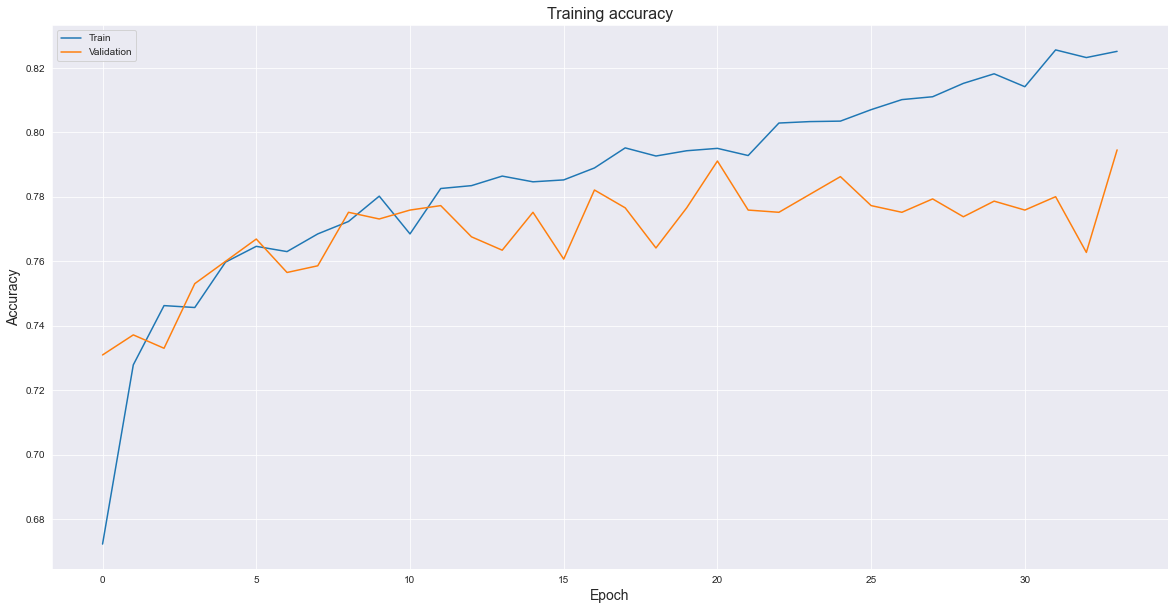

IOStream.flush timed out


<Figure size 432x288 with 0 Axes>

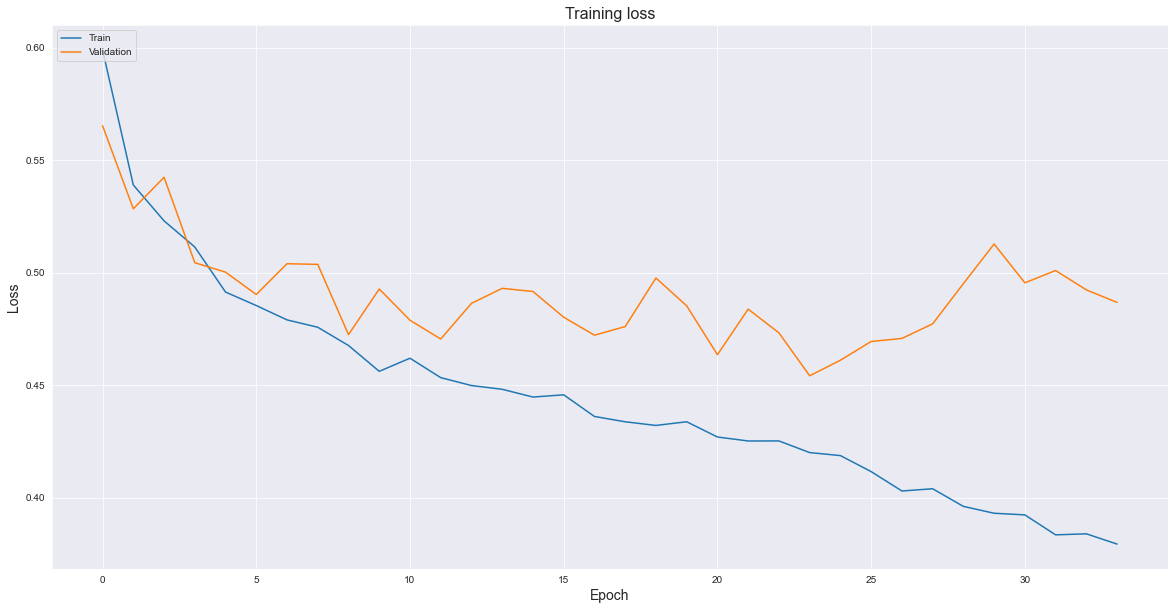

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.8631834086113456
validation dataset AUPRC: 0.84644826448682
validation dataset acc: 0.7946058091286307
validation dataset F1: 0.8005372733378107
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---Fold2/5---
---Processing training data---


100%|██████████| 2640/2640 [00:20<00:00, 127.65it/s]


---Processing validation data---


100%|██████████| 566/566 [00:05<00:00, 99.18it/s] 


---Start training process---
Epoch 1/40
106/106 [==============================] - 24s 220ms/step - loss: 0.4188 - accuracy: 0.8022 - val_loss: 0.4001 - val_accuracy: 0.8264 - lr: 5.0000e-04
Epoch 2/40
106/106 [==============================] - 26s 241ms/step - loss: 0.3972 - accuracy: 0.8144 - val_loss: 0.4047 - val_accuracy: 0.8147 - lr: 5.0000e-04
Epoch 3/40
106/106 [==============================] - 25s 235ms/step - loss: 0.3855 - accuracy: 0.8154 - val_loss: 0.4154 - val_accuracy: 0.8119 - lr: 5.0000e-04
Epoch 4/40
106/106 [==============================] - 25s 238ms/step - loss: 0.3788 - accuracy: 0.8172 - val_loss: 0.4291 - val_accuracy: 0.8084 - lr: 5.0000e-04
Epoch 5/40
106/106 [==============================] - 27s 256ms/step - loss: 0.3739 - accuracy: 0.8218 - val_loss: 0.4267 - val_accuracy: 0.8071 - lr: 5.0000e-04
Epoch 6/40
106/106 [==============================] - 25s 231ms/step - loss: 0.3658 - accuracy: 0.8301 - val_loss: 0.4320 - val_accuracy: 0.8160 - lr: 5.0000e-04

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

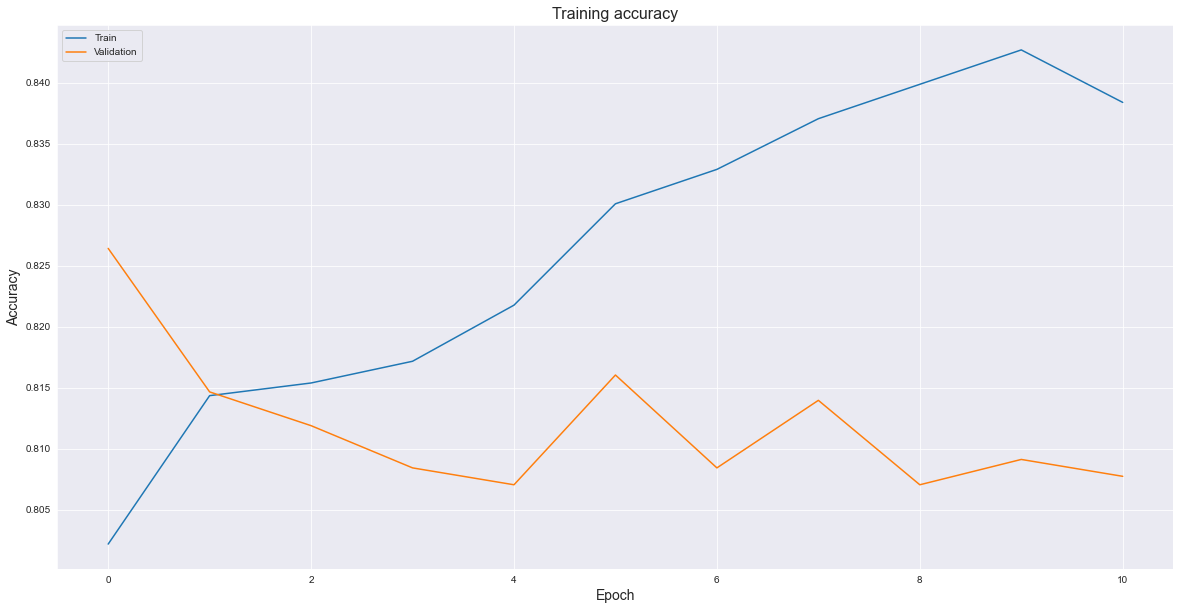

<Figure size 432x288 with 0 Axes>

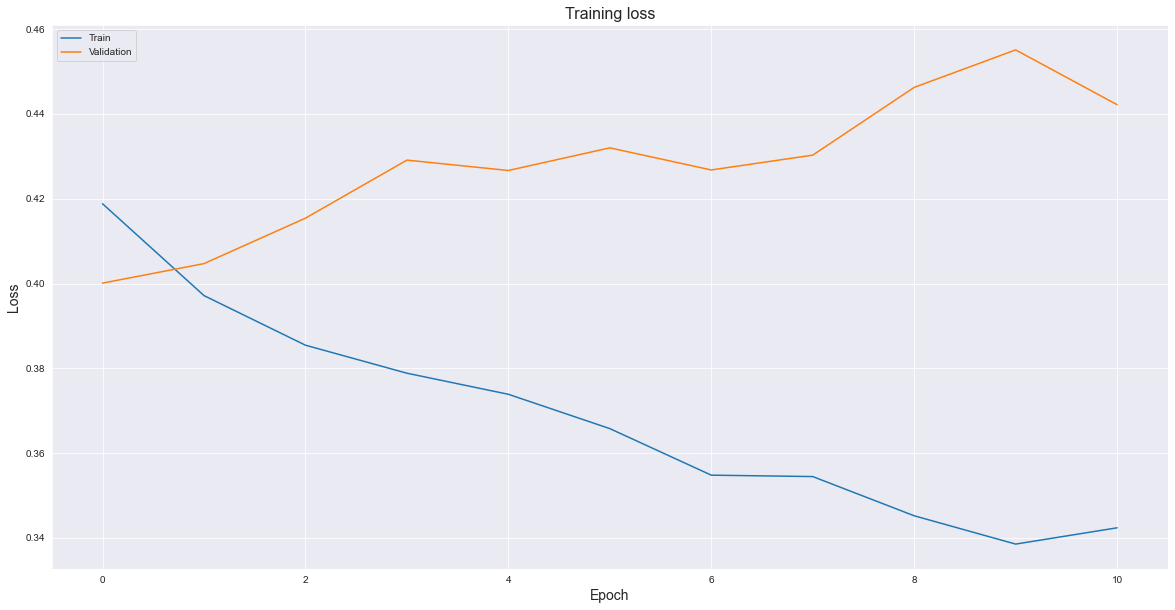

 Predicting on validation data...
validation dataset AUROC: 0.8882996734445574
validation dataset AUPRC: 0.882577904072434
validation dataset acc: 0.8077455048409405
validation dataset F1: 0.8036723163841808
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---Fold3/5---
---Processing training data---


100%|██████████| 2640/2640 [00:22<00:00, 115.88it/s]


---Processing validation data---


100%|██████████| 566/566 [00:05<00:00, 98.69it/s] 


---Start training process---
Epoch 1/40
106/106 [==============================] - 21s 197ms/step - loss: 0.3731 - accuracy: 0.8319 - val_loss: 0.3986 - val_accuracy: 0.8119 - lr: 2.5000e-04
Epoch 2/40
106/106 [==============================] - 24s 231ms/step - loss: 0.3510 - accuracy: 0.8396 - val_loss: 0.4082 - val_accuracy: 0.8181 - lr: 2.5000e-04
Epoch 3/40
106/106 [==============================] - 27s 258ms/step - loss: 0.3466 - accuracy: 0.8416 - val_loss: 0.3963 - val_accuracy: 0.8105 - lr: 2.5000e-04
Epoch 4/40
106/106 [==============================] - 27s 255ms/step - loss: 0.3380 - accuracy: 0.8486 - val_loss: 0.3987 - val_accuracy: 0.8154 - lr: 2.5000e-04
Epoch 5/40
106/106 [==============================] - 26s 243ms/step - loss: 0.3282 - accuracy: 0.8517 - val_loss: 0.4130 - val_accuracy: 0.8119 - lr: 2.5000e-04
Epoch 6/40
106/106 [==============================] - 26s 250ms/step - loss: 0.3208 - accuracy: 0.8553 - val_loss: 0.4241 - val_accuracy: 0.8126 - lr: 2.5000e-04

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

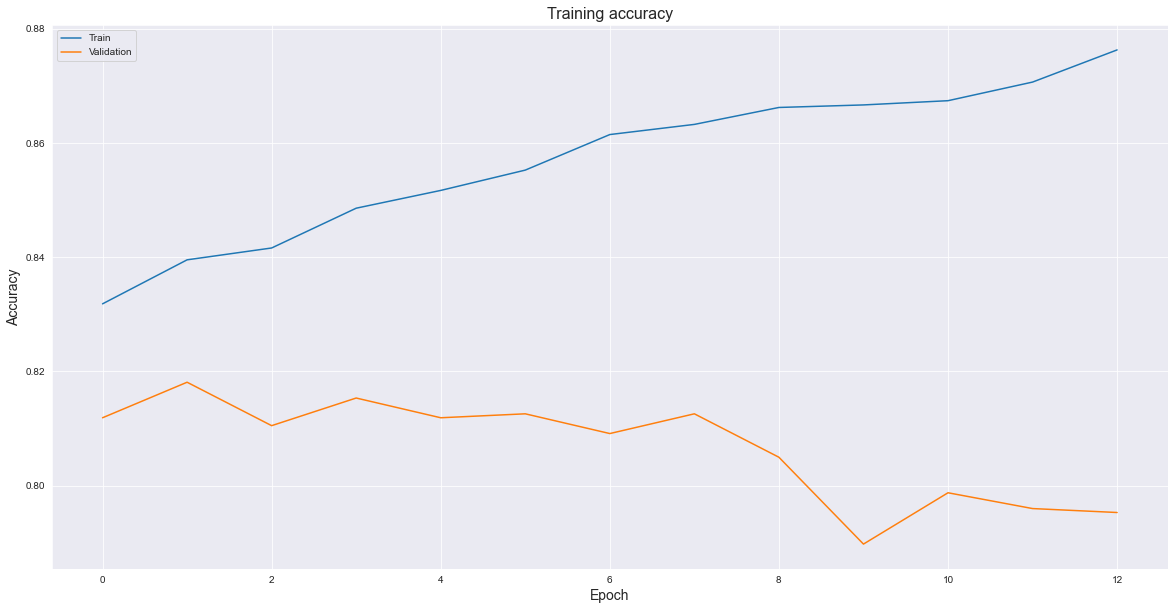

<Figure size 432x288 with 0 Axes>

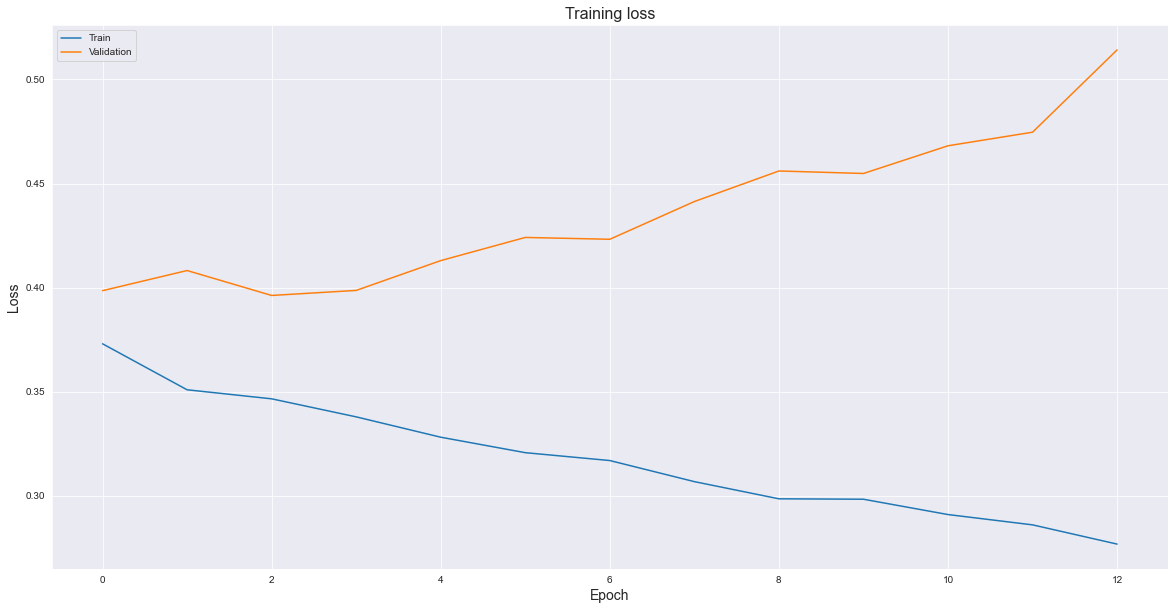

 Predicting on validation data...
validation dataset AUROC: 0.8826810833146812
validation dataset AUPRC: 0.8757884741225432
validation dataset acc: 0.7952973720608575
validation dataset F1: 0.8072916666666666
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---Fold4/5---
---Processing training data---


100%|██████████| 2640/2640 [00:23<00:00, 111.91it/s]


---Processing validation data---


100%|██████████| 566/566 [00:04<00:00, 140.69it/s]


---Start training process---
Epoch 1/40
106/106 [==============================] - 20s 190ms/step - loss: 0.3509 - accuracy: 0.8434 - val_loss: 0.3255 - val_accuracy: 0.8575 - lr: 1.2500e-04
Epoch 2/40
106/106 [==============================] - 25s 235ms/step - loss: 0.3258 - accuracy: 0.8539 - val_loss: 0.3276 - val_accuracy: 0.8506 - lr: 1.2500e-04
Epoch 3/40
106/106 [==============================] - 27s 253ms/step - loss: 0.3134 - accuracy: 0.8602 - val_loss: 0.3266 - val_accuracy: 0.8555 - lr: 1.2500e-04
Epoch 4/40
106/106 [==============================] - 23s 217ms/step - loss: 0.3103 - accuracy: 0.8611 - val_loss: 0.3401 - val_accuracy: 0.8506 - lr: 1.2500e-04
Epoch 5/40
106/106 [==============================] - 24s 223ms/step - loss: 0.3028 - accuracy: 0.8660 - val_loss: 0.3481 - val_accuracy: 0.8451 - lr: 1.2500e-04
Epoch 6/40
106/106 [==============================] - 23s 217ms/step - loss: 0.2907 - accuracy: 0.8720 - val_loss: 0.3453 - val_accuracy: 0.8451 - lr: 1.2500e-04

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

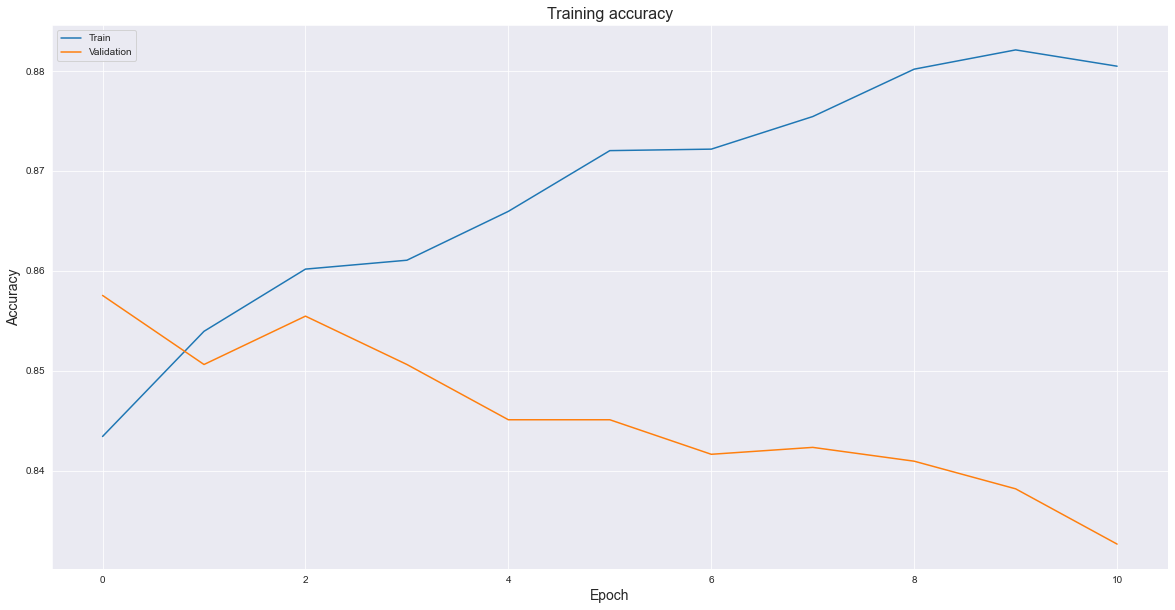

<Figure size 432x288 with 0 Axes>

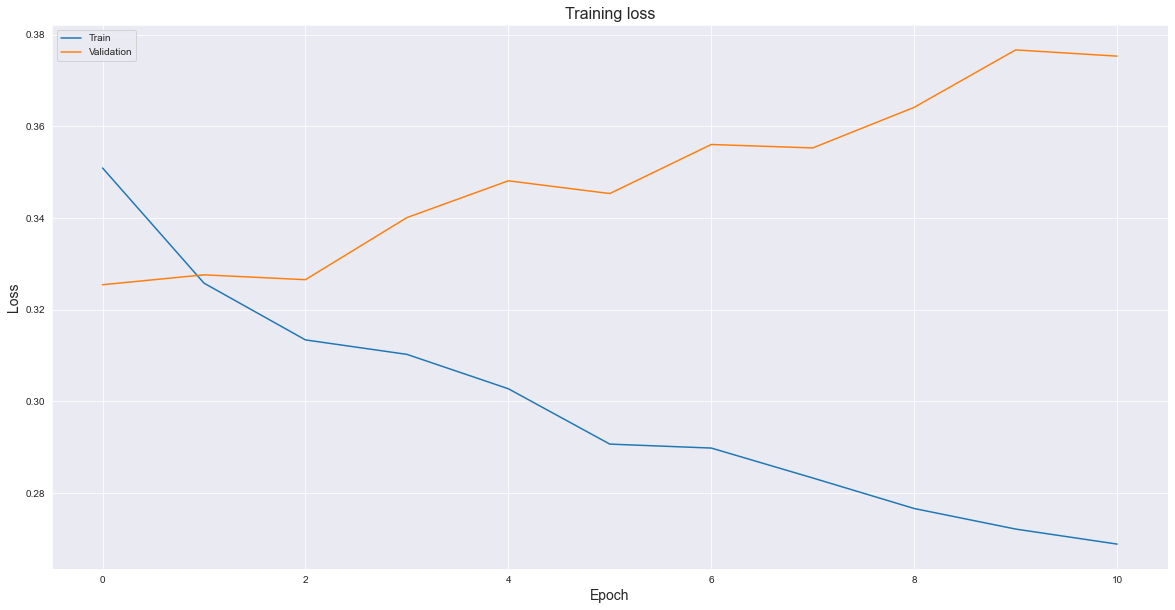

 Predicting on validation data...
validation dataset AUROC: 0.9205324365015141
validation dataset AUPRC: 0.9034487873183625
validation dataset acc: 0.8326417704011065
validation dataset F1: 0.829817158931083
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---Fold5/5---
---Processing training data---


100%|██████████| 2640/2640 [00:22<00:00, 116.76it/s]


---Processing validation data---


100%|██████████| 566/566 [00:03<00:00, 158.34it/s]


---Start training process---
Epoch 1/40
106/106 [==============================] - 22s 209ms/step - loss: 0.3173 - accuracy: 0.8609 - val_loss: 0.2928 - val_accuracy: 0.8700 - lr: 6.2500e-05
Epoch 2/40
106/106 [==============================] - 26s 243ms/step - loss: 0.3032 - accuracy: 0.8663 - val_loss: 0.2940 - val_accuracy: 0.8686 - lr: 6.2500e-05
Epoch 3/40
106/106 [==============================] - 23s 219ms/step - loss: 0.2955 - accuracy: 0.8729 - val_loss: 0.2946 - val_accuracy: 0.8714 - lr: 6.2500e-05
Epoch 4/40
106/106 [==============================] - 22s 205ms/step - loss: 0.2883 - accuracy: 0.8754 - val_loss: 0.2957 - val_accuracy: 0.8679 - lr: 6.2500e-05
Epoch 5/40
106/106 [==============================] - 23s 222ms/step - loss: 0.2859 - accuracy: 0.8769 - val_loss: 0.2978 - val_accuracy: 0.8665 - lr: 6.2500e-05
Epoch 6/40
106/106 [==============================] - 28s 266ms/step - loss: 0.2821 - accuracy: 0.8803 - val_loss: 0.2988 - val_accuracy: 0.8658 - lr: 6.2500e-05

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

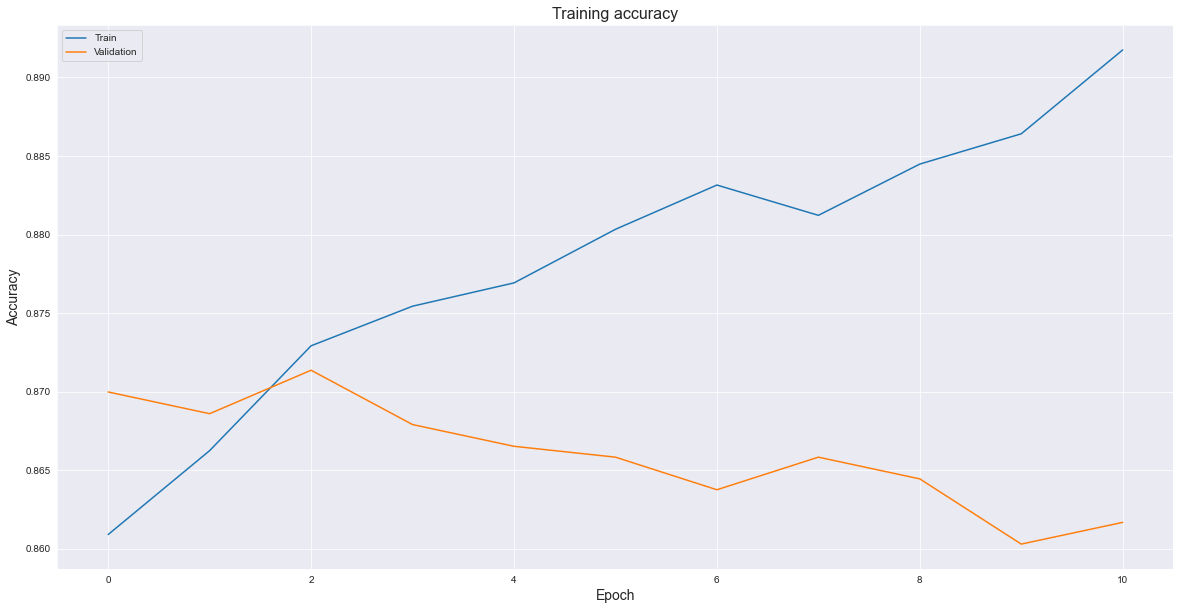

<Figure size 432x288 with 0 Axes>

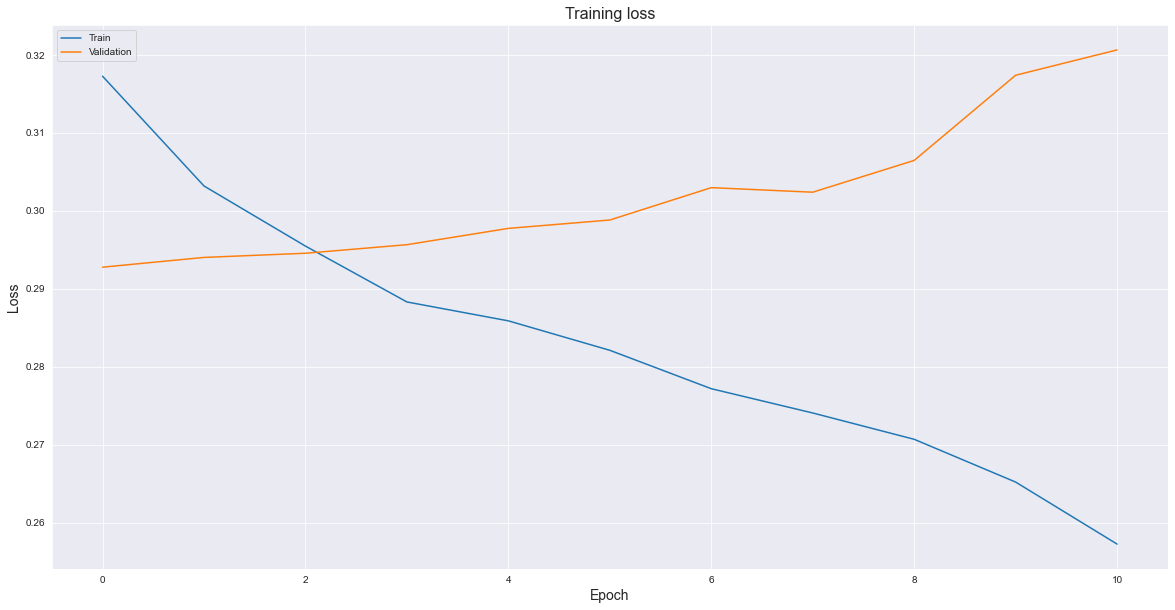

 Predicting on validation data...
validation dataset AUROC: 0.9390468101061927
validation dataset AUPRC: 0.9319509950131413
validation dataset acc: 0.8616874135546335
validation dataset F1: 0.8632010943912448
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Averaged trauining results:
 F1_score:0.8209039019421972
 Accuracy:0.8183955739972337
 AUROC:0.8987486823956582
 AUPRC:0.88804288500266



<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

In [15]:
# define the optimized model from previous step
optimized_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128,return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
optimized_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

f1_list = []
accuracy_list = []
auprc_list = []
auroc_list = []
# 5-fold cross validation was implemented and five LSTM models were produced
sss = StratifiedShuffleSplit(n_splits=5, test_size = 3/17, random_state=np.random.seed(12306)) # val/train = 0.15/0.7
for (k, (train0_index, val0_index)), (k, (train1_index, val1_index)), (k, (train2_index, val2_index)), (k, (train3_index, val3_index))\
     in zip(enumerate(sss.split(train_nonsepsis_c, np.zeros(train_nonsepsis_c.shape))), enumerate(sss.split(train_sepsis_c, np.zeros(train_sepsis_c.shape))), enumerate(sss.split(train_nonsepsis_m, np.zeros(train_nonsepsis_m.shape))), enumerate(sss.split(train_sepsis_m, np.zeros(train_sepsis_m.shape)))):

    print('---Fold{}/5---'.format(k+1))

    print('---Processing training data---')
    # train_set_c = np.append((train_nonsepsis_c[train0_index])[:20], (train_sepsis_c[train1_index])[:20])
    train_set_c = np.append((train_nonsepsis_c[train0_index])[:2052], (train_sepsis_c[train1_index])[:2052])
    x_train_c, y_train_c = process_data(train_set_c, data_path_c, X_feature_baseline)

    # train_set_m = np.append((train_nonsepsis_m[train2_index][:13]), (train_sepsis_m[train3_index])[:13])
    train_set_m = np.append((train_nonsepsis_m[train2_index][:1320]), (train_sepsis_m[train3_index])[:1320])
    x_train_m, y_train_m = process_data(train_set_m, data_path_m, X_feature_baseline)

    x_train = np.concatenate((x_train_c, x_train_m))
    y_train = np.concatenate((y_train_c, y_train_m))


    print('---Processing validation data---')
    # val_set_c = np.append((train_nonsepsis_c[val0_index])[:4], (train_sepsis_c[val1_index][:4]))
    val_set_c = np.append((train_nonsepsis_c[val0_index])[:440], (train_sepsis_c[val1_index][:440]))
    x_val_c, y_val_c = process_data(val_set_c, data_path_c, X_feature_baseline)

    # val_set_m = np.append((train_nonsepsis_m[val2_index])[:2], (train_sepsis_m[val3_index])[:2])
    val_set_m = np.append((train_nonsepsis_m[val2_index])[:283], (train_sepsis_m[val3_index])[:283])
    x_val_m, y_val_m = process_data(val_set_m, data_path_m, X_feature_baseline)

    x_val = np.concatenate((x_val_c, x_val_m))
    y_val = np.concatenate((y_val_c, y_val_m))

    print('---Start training process---')

    # get the feature importance
    metrics = get_feature_importance(optimized_model, 64, x_train, y_train, x_val, y_val, k, X_feature_baseline, 'bd_wo_fs', 'BDWOFS')
    accuracy_list.append(metrics[0])
    f1_list.append(metrics[1])
    auroc_list.append(metrics[2])
    auprc_list.append(metrics[3])

def Average(lst):
    return sum(lst) / len(lst)

print('Averaged validation results:\n F1_score:{}\n Accuracy:{}\n AUROC:{}\n AUPRC:{}\n'.format(Average(f1_list),Average(accuracy_list), Average(auroc_list), Average(auprc_list)))

### Tune Hyperparameter with FS

In [50]:
X_feature_baseline_fs = ['HR', 'SaO2', 'Temp', 'SBP', 'MAP', 
                            'DBP', 'RR', 'HCO3','BUN', 'Calcium', 
                            'Chloride', 'Glucose', 'PTT', 'WBC', 'Platelet']
y_feature = ['sepsis']

### Train with FS 

---Fold1/5---
---Processing training data---


100%|██████████| 2640/2640 [00:19<00:00, 135.41it/s]


---Processing validation data---


100%|██████████| 566/566 [00:03<00:00, 159.04it/s]


---Start training process---
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
106/106 [==============================] - ETA: 0s - loss: 0.6084 - accuracy: 0.6621WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fb491a588c0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
106/106 [==============================] - 38s 246ms/step - loss: 0.6084 - accuracy: 0.6621 - val_loss: 0

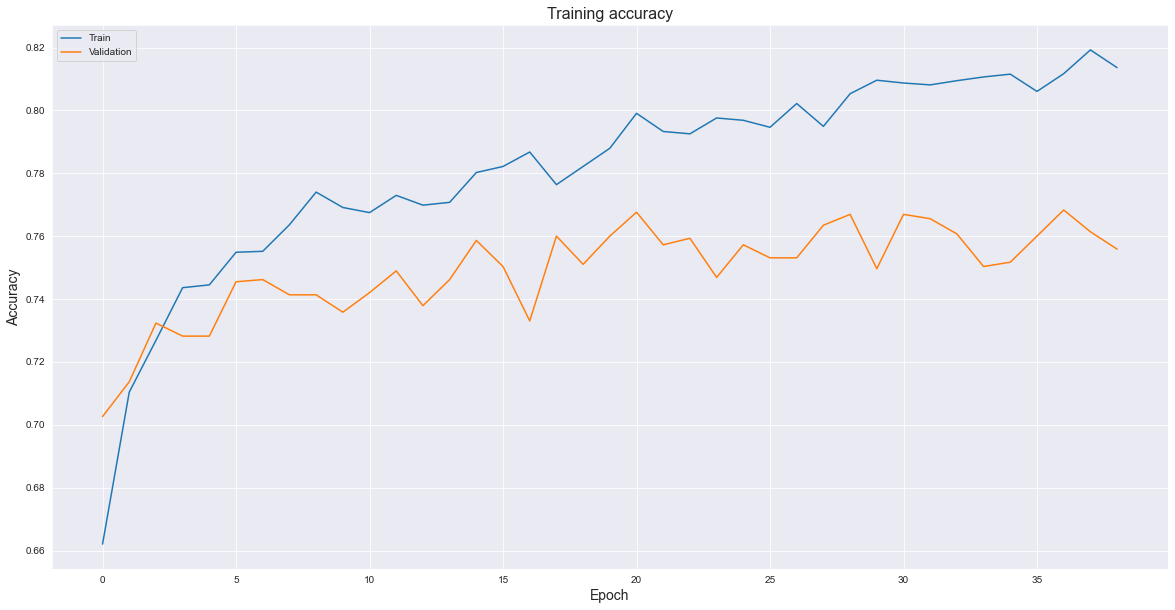

<Figure size 432x288 with 0 Axes>

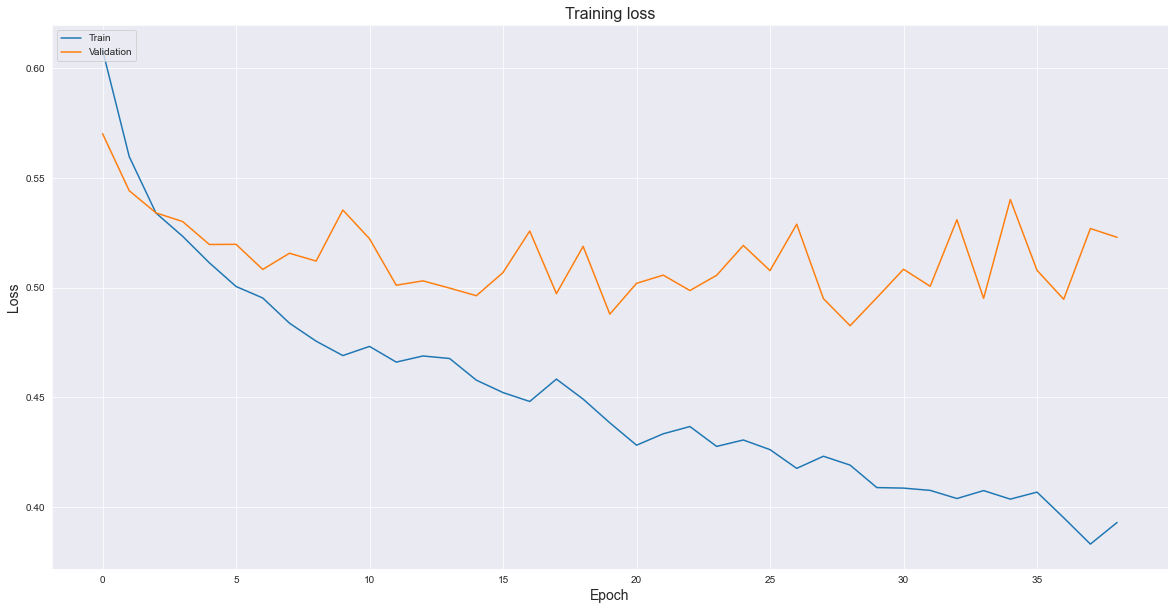

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.8382029694162749
validation dataset AUPRC: 0.8400956180660182
validation dataset acc: 0.7558782849239281
validation dataset F1: 0.7648234510326448
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---Fold2/5---
---Processing training data---


100%|██████████| 2640/2640 [00:18<00:00, 145.95it/s]


---Processing validation data---


100%|██████████| 566/566 [00:03<00:00, 149.65it/s]


---Start training process---
Epoch 1/40
106/106 [==============================] - 20s 184ms/step - loss: 0.4396 - accuracy: 0.7946 - val_loss: 0.4361 - val_accuracy: 0.7925 - lr: 5.0000e-04
Epoch 2/40
106/106 [==============================] - 20s 186ms/step - loss: 0.4200 - accuracy: 0.8081 - val_loss: 0.4349 - val_accuracy: 0.7842 - lr: 5.0000e-04
Epoch 3/40
106/106 [==============================] - 20s 184ms/step - loss: 0.4148 - accuracy: 0.8058 - val_loss: 0.4461 - val_accuracy: 0.7828 - lr: 5.0000e-04
Epoch 4/40
106/106 [==============================] - 20s 186ms/step - loss: 0.4009 - accuracy: 0.8102 - val_loss: 0.4390 - val_accuracy: 0.7884 - lr: 5.0000e-04
Epoch 5/40
106/106 [==============================] - 20s 184ms/step - loss: 0.3903 - accuracy: 0.8201 - val_loss: 0.4460 - val_accuracy: 0.7946 - lr: 5.0000e-04
Epoch 6/40
106/106 [==============================] - 20s 184ms/step - loss: 0.3843 - accuracy: 0.8221 - val_loss: 0.4401 - val_accuracy: 0.7918 - lr: 5.0000e-04

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

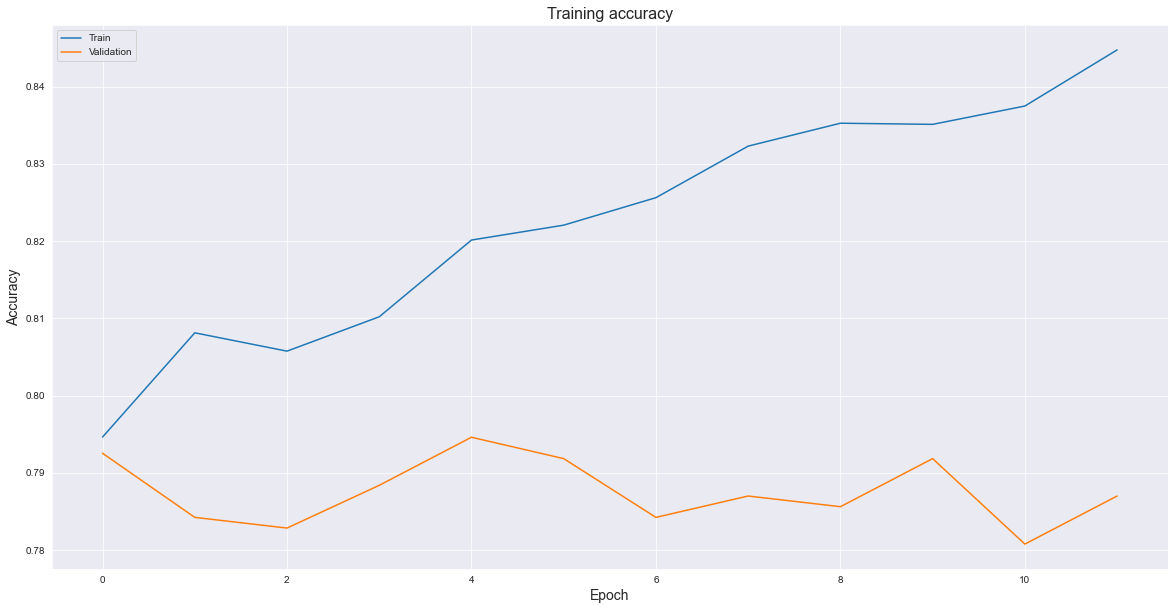

<Figure size 432x288 with 0 Axes>

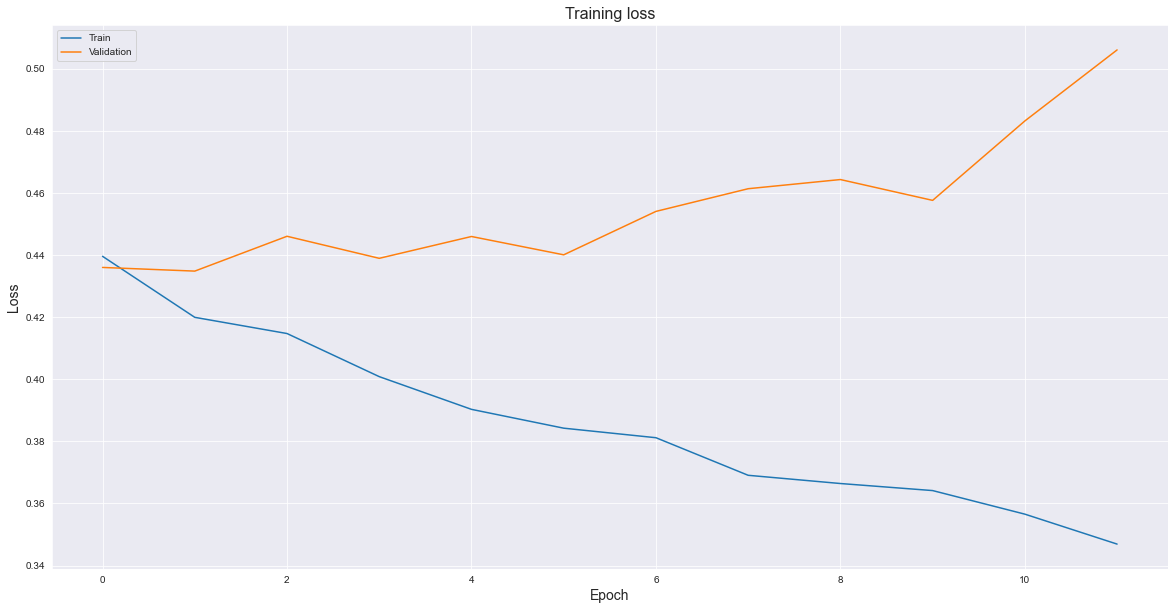

 Predicting on validation data...
validation dataset AUROC: 0.8603836787321919
validation dataset AUPRC: 0.8628315524030817
validation dataset acc: 0.7869986168741355
validation dataset F1: 0.7901907356948229
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---Fold3/5---
---Processing training data---


100%|██████████| 2640/2640 [00:16<00:00, 161.28it/s]


---Processing validation data---


100%|██████████| 566/566 [00:03<00:00, 150.67it/s]


---Start training process---
Epoch 1/40
106/106 [==============================] - 20s 192ms/step - loss: 0.3955 - accuracy: 0.8216 - val_loss: 0.3935 - val_accuracy: 0.8202 - lr: 2.5000e-04
Epoch 2/40
106/106 [==============================] - 20s 184ms/step - loss: 0.3698 - accuracy: 0.8351 - val_loss: 0.3920 - val_accuracy: 0.8216 - lr: 2.5000e-04
Epoch 3/40
106/106 [==============================] - 20s 186ms/step - loss: 0.3557 - accuracy: 0.8387 - val_loss: 0.3889 - val_accuracy: 0.8250 - lr: 2.5000e-04
Epoch 4/40
106/106 [==============================] - 20s 190ms/step - loss: 0.3506 - accuracy: 0.8450 - val_loss: 0.4005 - val_accuracy: 0.8243 - lr: 2.5000e-04
Epoch 5/40
106/106 [==============================] - 20s 193ms/step - loss: 0.3371 - accuracy: 0.8511 - val_loss: 0.4000 - val_accuracy: 0.8202 - lr: 2.5000e-04
Epoch 6/40
106/106 [==============================] - 21s 190ms/step - loss: 0.3315 - accuracy: 0.8544 - val_loss: 0.4170 - val_accuracy: 0.8223 - lr: 2.5000e-04

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

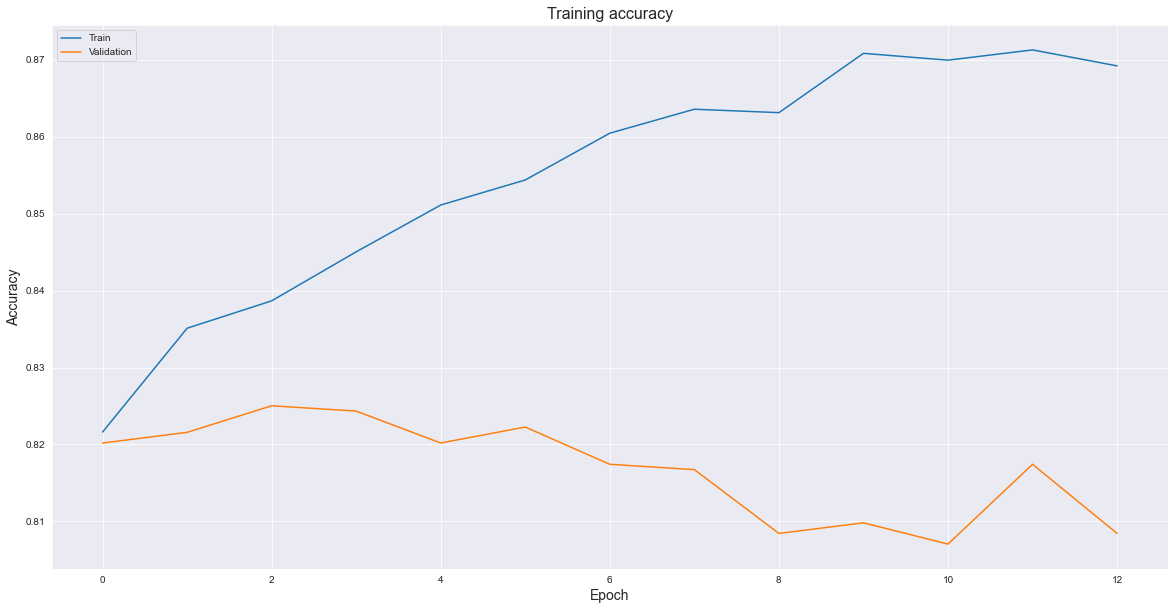

<Figure size 432x288 with 0 Axes>

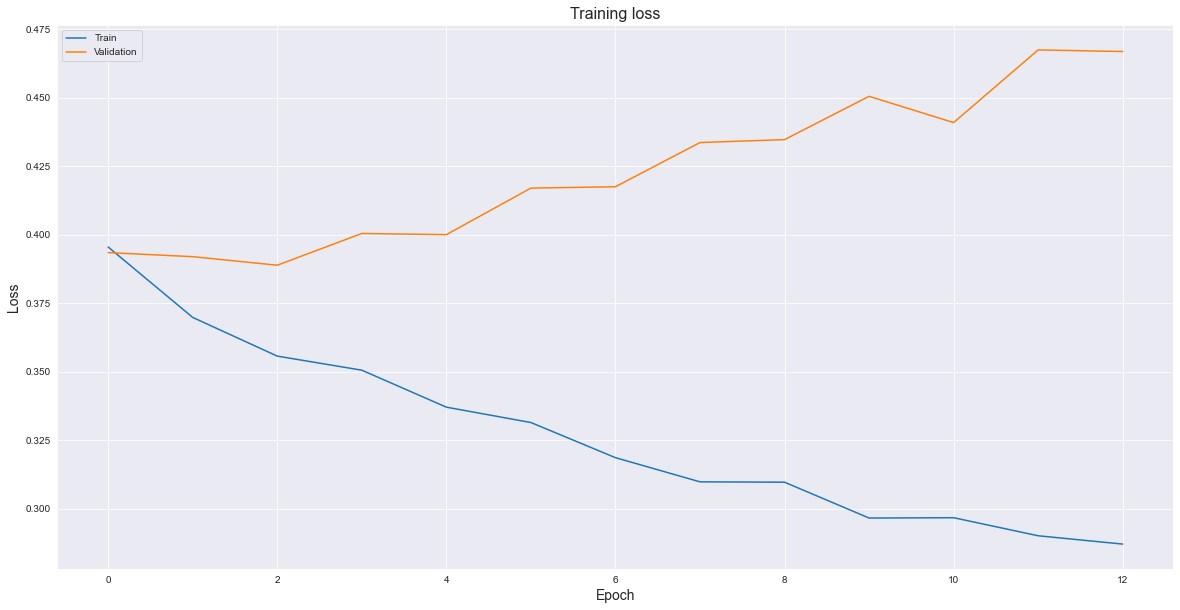

 Predicting on validation data...
validation dataset AUROC: 0.8903294058680501
validation dataset AUPRC: 0.8894836119074402
validation dataset acc: 0.8084370677731674
validation dataset F1: 0.8161911081619111
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---Fold4/5---
---Processing training data---


100%|██████████| 2640/2640 [00:16<00:00, 157.42it/s]


---Processing validation data---


100%|██████████| 566/566 [00:04<00:00, 137.52it/s]


---Start training process---
Epoch 1/40
106/106 [==============================] - 19s 183ms/step - loss: 0.3584 - accuracy: 0.8415 - val_loss: 0.3195 - val_accuracy: 0.8513 - lr: 1.2500e-04
Epoch 2/40
106/106 [==============================] - 20s 185ms/step - loss: 0.3306 - accuracy: 0.8557 - val_loss: 0.3193 - val_accuracy: 0.8582 - lr: 1.2500e-04
Epoch 3/40
106/106 [==============================] - 20s 188ms/step - loss: 0.3168 - accuracy: 0.8643 - val_loss: 0.3365 - val_accuracy: 0.8465 - lr: 1.2500e-04
Epoch 4/40
106/106 [==============================] - 20s 190ms/step - loss: 0.3098 - accuracy: 0.8667 - val_loss: 0.3322 - val_accuracy: 0.8520 - lr: 1.2500e-04
Epoch 5/40
106/106 [==============================] - 22s 210ms/step - loss: 0.3041 - accuracy: 0.8697 - val_loss: 0.3327 - val_accuracy: 0.8485 - lr: 1.2500e-04
Epoch 6/40
106/106 [==============================] - 22s 204ms/step - loss: 0.2968 - accuracy: 0.8756 - val_loss: 0.3346 - val_accuracy: 0.8458 - lr: 1.2500e-04

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

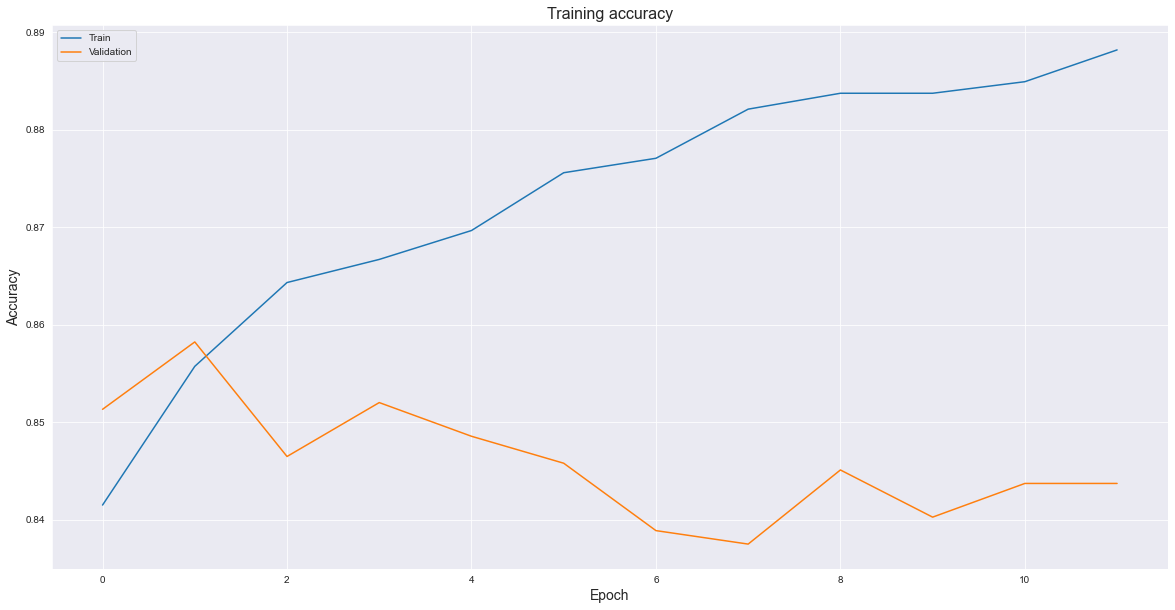

<Figure size 432x288 with 0 Axes>

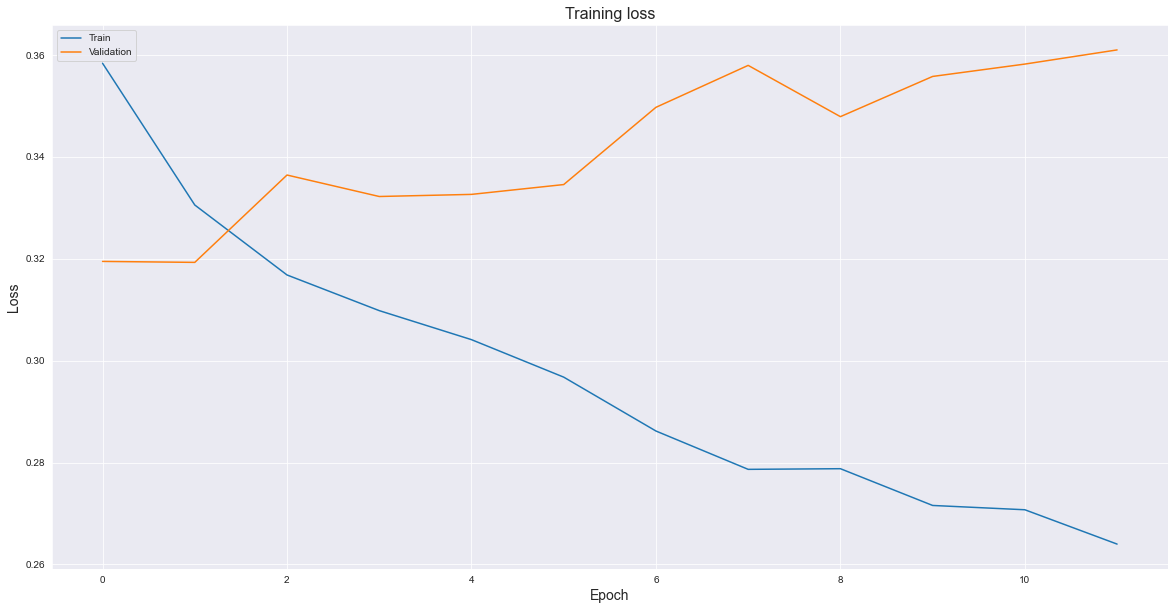

 Predicting on validation data...
validation dataset AUROC: 0.9231532974064957
validation dataset AUPRC: 0.9180799495748353
validation dataset acc: 0.8437067773167358
validation dataset F1: 0.8449931412894376
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---Fold5/5---
---Processing training data---


100%|██████████| 2640/2640 [00:17<00:00, 153.04it/s]


---Processing validation data---


100%|██████████| 566/566 [00:03<00:00, 158.72it/s]


---Start training process---
Epoch 1/40
106/106 [==============================] - 20s 189ms/step - loss: 0.3185 - accuracy: 0.8667 - val_loss: 0.3293 - val_accuracy: 0.8562 - lr: 6.2500e-05
Epoch 2/40
106/106 [==============================] - 21s 193ms/step - loss: 0.2996 - accuracy: 0.8720 - val_loss: 0.3301 - val_accuracy: 0.8534 - lr: 6.2500e-05
Epoch 3/40
106/106 [==============================] - 24s 224ms/step - loss: 0.2925 - accuracy: 0.8783 - val_loss: 0.3303 - val_accuracy: 0.8555 - lr: 6.2500e-05
Epoch 4/40
106/106 [==============================] - 24s 222ms/step - loss: 0.2919 - accuracy: 0.8780 - val_loss: 0.3328 - val_accuracy: 0.8534 - lr: 6.2500e-05
Epoch 5/40
106/106 [==============================] - 22s 206ms/step - loss: 0.2816 - accuracy: 0.8824 - val_loss: 0.3356 - val_accuracy: 0.8527 - lr: 6.2500e-05
Epoch 6/40
106/106 [==============================] - 19s 183ms/step - loss: 0.2808 - accuracy: 0.8793 - val_loss: 0.3387 - val_accuracy: 0.8513 - lr: 6.2500e-05

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

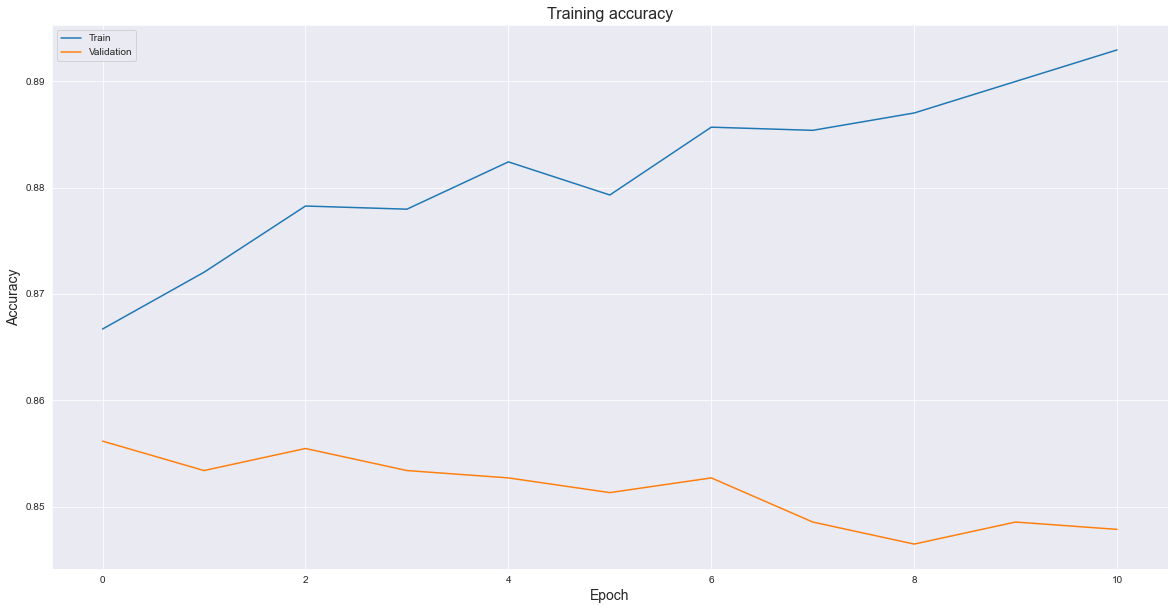

<Figure size 432x288 with 0 Axes>

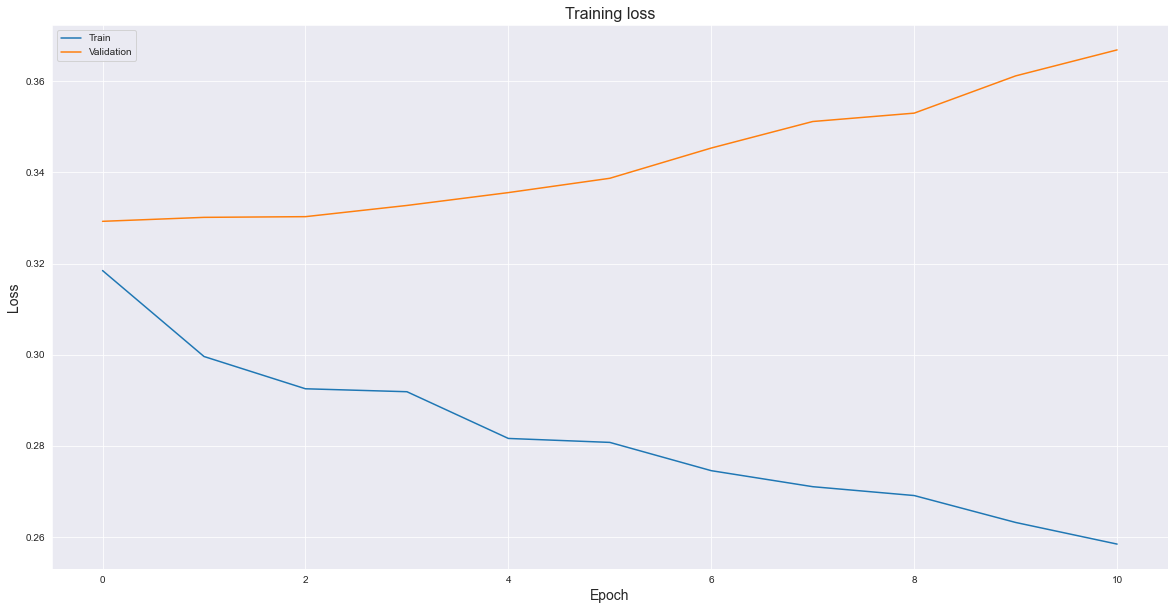

 Predicting on validation data...
validation dataset AUROC: 0.9191607888600021
validation dataset AUPRC: 0.9028659085319177
validation dataset acc: 0.8478561549100968
validation dataset F1: 0.8543046357615894
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Averaged validation results:
 F1_score:0.814100614388081
 Accuracy:0.8085753803596127
 AUROC:0.8862460280566029
 AUPRC:0.8826713280966587



<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

In [25]:
# define the optimized model from previous step
optimized_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128,return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
optimized_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

f1_list = []
accuracy_list = []
auprc_list = []
auroc_list = []
# 5-fold cross validation was implemented and five LSTM models were produced
sss = StratifiedShuffleSplit(n_splits=5, test_size = 3/17, random_state=np.random.seed(12306)) # val/train = 0.15/0.7
for (k, (train0_index, val0_index)), (k, (train1_index, val1_index)), (k, (train2_index, val2_index)), (k, (train3_index, val3_index))\
     in zip(enumerate(sss.split(train_nonsepsis_c, np.zeros(train_nonsepsis_c.shape))), enumerate(sss.split(train_sepsis_c, np.zeros(train_sepsis_c.shape))), enumerate(sss.split(train_nonsepsis_m, np.zeros(train_nonsepsis_m.shape))), enumerate(sss.split(train_sepsis_m, np.zeros(train_sepsis_m.shape)))):

    print('---Fold{}/5---'.format(k+1))

    print('---Processing training data---')
    # train_set_c = np.append((train_nonsepsis_c[train0_index])[:20], (train_sepsis_c[train1_index])[:20])
    train_set_c = np.append((train_nonsepsis_c[train0_index])[:2052], (train_sepsis_c[train1_index])[:2052])
    x_train_c, y_train_c = process_data(train_set_c, data_path_c, X_feature_baseline_fs)

    # train_set_m = np.append((train_nonsepsis_m[train2_index][:13]), (train_sepsis_m[train3_index])[:13])
    train_set_m = np.append((train_nonsepsis_m[train2_index][:1320]), (train_sepsis_m[train3_index])[:1320])
    x_train_m, y_train_m = process_data(train_set_m, data_path_m, X_feature_baseline_fs)

    x_train = np.concatenate((x_train_c, x_train_m))
    y_train = np.concatenate((y_train_c, y_train_m))


    print('---Processing validation data---')
    # val_set_c = np.append((train_nonsepsis_c[val0_index])[:4], (train_sepsis_c[val1_index][:4]))
    val_set_c = np.append((train_nonsepsis_c[val0_index])[:440], (train_sepsis_c[val1_index][:440]))
    x_val_c, y_val_c = process_data(val_set_c, data_path_c, X_feature_baseline_fs)

    # val_set_m = np.append((train_nonsepsis_m[val2_index])[:2], (train_sepsis_m[val3_index])[:2])
    val_set_m = np.append((train_nonsepsis_m[val2_index])[:283], (train_sepsis_m[val3_index])[:283])
    x_val_m, y_val_m = process_data(val_set_m, data_path_m, X_feature_baseline_fs)

    x_val = np.concatenate((x_val_c, x_val_m))
    y_val = np.concatenate((y_val_c, y_val_m))

    print('---Start training process---')

    # get the feature importance
    metrics = get_feature_importance(optimized_model, 64, x_train, y_train, x_val, y_val, k, X_feature_baseline_fs, 'bd_w_fs', 'BDWFS')
    accuracy_list.append(metrics[0])
    f1_list.append(metrics[1])
    auroc_list.append(metrics[2])
    auprc_list.append(metrics[3])

def Average(lst):
    return sum(lst) / len(lst)

print('Averaged validation results:\n F1_score:{}\n Accuracy:{}\n AUROC:{}\n AUPRC:{}\n'.format(Average(f1_list),Average(accuracy_list), Average(auroc_list), Average(auprc_list)))

 ## Engineered Data

In [8]:
X_feature_engineered = ['HR', 'SaO2', 'Temp', 'SBP', 'MAP', 'DBP', 'RR', 'BaseExcess', 'HCO3',
       'PH', 'BUN', 'Calcium', 'Chloride', 'Creatinine', 'Glucose', 'Lactic',
       'Magnesium', 'Potassium', 'PTT', 'WBC', 'Platelet', 'age', 'gender',
       'HR_dev_1', 'HR_dev_2', 'HR_dev_3', 'RR_dev_1',
       'RR_dev_2', 'RR_dev_3', 'Temp_dev_1', 'Temp_dev_2', 'Temp_dev_3',
       'Bradycardia', 'Tachycardia', 'Hypothermia', 'Fever', 'Hyperpyrexia']
y_feature = ['sepsis']

In [9]:
#load data from Cinc2019
data_path_c = "../../datasets/Cinc2019/engineered_all/"  
train_nonsepsis_c = np.load('../data/data_Cinc2019/train_nonsepsis.npy')
train_sepsis_c = np.load('../data/data_Cinc2019/train_sepsis.npy')

# load data from MIMIC-III
data_path_m = "../../datasets/MIMICIII/adults/engineered_all/"  
train_nonsepsis_m = np.load('../data/data_mimiciii/train_nonsepsis.npy')
train_sepsis_m = np.load('../data/data_mimiciii/train_sepsis.npy')

### Tune Hyperparameter

In [10]:
def process_data_engineered(patient_ids, patients_path, data_features):
    # prepare data
    X_train = []
    y_train = []
    # total_X_data = []

    for i in tqdm(patient_ids):
        i = str(np.char.replace(i,'psv','csv'))
        # drop un-related data
        data = pd.read_csv(patients_path+i,sep = ',')
        data.drop(['subject_id'], axis = 1,inplace = True)
        if 'time' in data.columns: 
            data.drop(['time'], axis = 1,inplace = True)
        
        data = data.replace([True, False],[1,0])
        
        # to label whether this patient has sepsis or not,
        # leave only one label for one .psv file (patient)
        label_sepsis = data['sepsis'].sum()
        if label_sepsis:
            y_train.append(1)
        else:
            y_train.append(0)
        data.drop(['sepsis'],axis = 1,inplace = True)
        
        # this empty row need to be changed for engineered data
        empty_row = {'HR':0, 'SaO2':0, 'Temp':0, 'SBP':0, 'MAP':0, 'DBP':0, 'RR':0, 'BaseExcess':0, 'HCO3':0,
                    'PH':0, 'BUN':0, 'Calcium':0, 'Chloride':0, 'Creatinine':0, 'Glucose':0, 'Lactic':0,
                    'Magnesium':0, 'Potassium':0, 'PTT':0, 'WBC':0, 'Platelet':0, 'age':data['age'][0], 'gender':data['gender'][0],
                    'HR_dev_1':0, 'HR_dev_2':0, 'HR_dev_3':0, 'RR_dev_1':0, 'RR_dev_2':0, 'RR_dev_3':0, 'Temp_dev_1':0, 'Temp_dev_2':0, 'Temp_dev_3':0,
                    'Bradycardia':0, 'Tachycardia':0, 'Hypothermia':0, 'Fever':0, 'Hyperpyrexia':0}

        # unify the length of the input data
        if len(data) < 40:
            Pad = pd.DataFrame(empty_row, index =[item for item in range(0,40-len(data))])
            data = pd.concat([Pad, data]).reset_index(drop = True)
            # data = data.reindex(range(40),fill_value = 0) # use this line to padd zeros at the data end
        elif len(data) > 40:
            data = data[len(data)-40::1]
        data = data.reset_index(drop = True)

        data = data[data_features] # re-arrange the order of features before converting to array

        # total_X_data = pd.concat([total_X_data, data]).reset_index(drop = True)

        data = data.values.astype(np.float64) # from DataFrame to numpy array
        X_train.append(data)

    return X_train, y_train

In [ ]:
# process training data
print('---Processing training data---')
train_set_c = np.append(train_nonsepsis_c[:2052], train_sepsis_c[:2052])
x_train_c, y_train_c = process_data_engineered(train_set_c, data_path_c, X_feature_engineered)

train_set_m = np.append(train_nonsepsis_m[:1320], train_sepsis_m[:1320])
x_train_m, y_train_m = process_data_engineered(train_set_m, data_path_m, X_feature_engineered)

x_train = np.concatenate((x_train_c, x_train_m))
y_train = np.concatenate((y_train_c, y_train_m))

# process validation data
print('---Processing validation data---')
val_set_c = np.append(train_nonsepsis_c[:440], train_sepsis_c[:440])
x_val_c, y_val_c = process_data_engineered(val_set_c, data_path_c, X_feature_engineered)

val_set_m = np.append(train_nonsepsis_m[:283], train_sepsis_m[:283])
x_val_m, y_val_m = process_data_engineered(val_set_m, data_path_m, X_feature_engineered)

x_val = np.concatenate((x_val_c, x_val_m))
y_val = np.concatenate((y_val_c, y_val_m))


print(np.any(pd.isnull(x_train)))
print(np.any(pd.isnull(y_train)))
print(x_train)
print(y_train)

#tune hyperparameter
print('---Tuning Hyperparameters---')
config =  [[False, True], [False, True], [False, True], [128, 64], [64, 32], [0.2, 0.1], [1e-3, 1e-2]]  
    # list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout], [learning_rate]]

hist = LSTM_HyperParameter_Tuning(config, x_train, y_train, x_val, y_val, 'engineered_wo_fs')
print(hist)


99-th combination = (True, True, False, 128, 64, 0.1, 0.001) 
 train loss: [0.6688992381095886, 0.0] and test loss: [0.6725621223449707, 0.0]

### Select Features

---Fold1/5---
---Processing training data---


100%|██████████| 2640/2640 [00:24<00:00, 108.72it/s]


---Processing validation data---


100%|██████████| 566/566 [00:07<00:00, 76.25it/s] 


---Start training process---
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
106/106 [==============================] - ETA: 0s - loss: 0.5931 - accuracy: 0.6738WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fb488fb79e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
106/106 [==============================] - 47s 332ms/step - loss: 0.5931 - accuracy: 0.6738 - val_loss: 0

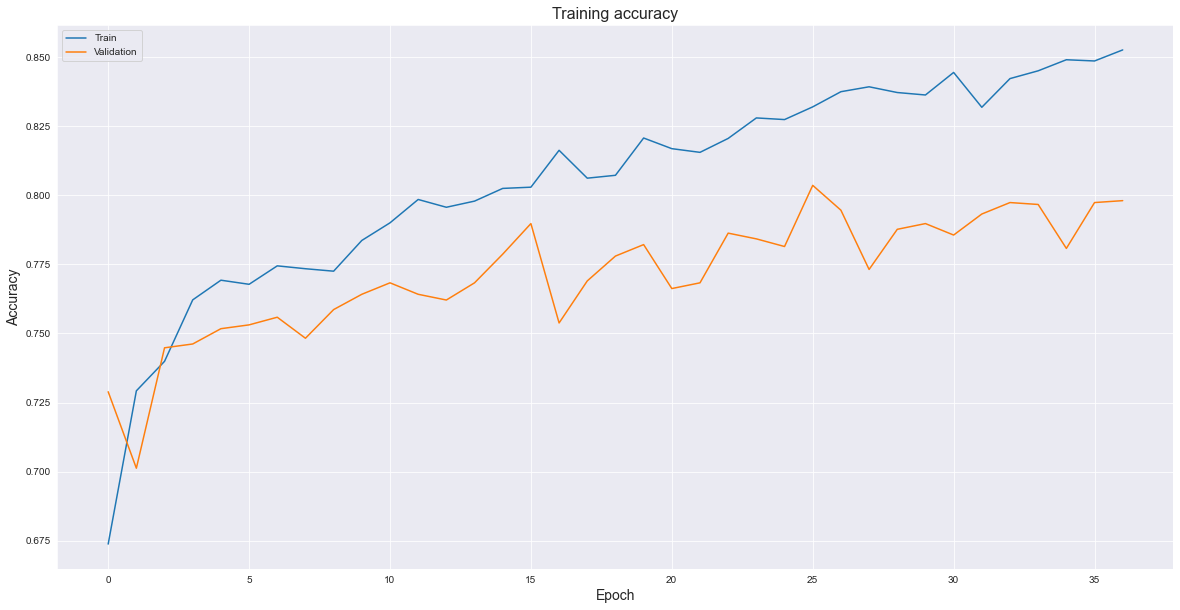

<Figure size 432x288 with 0 Axes>

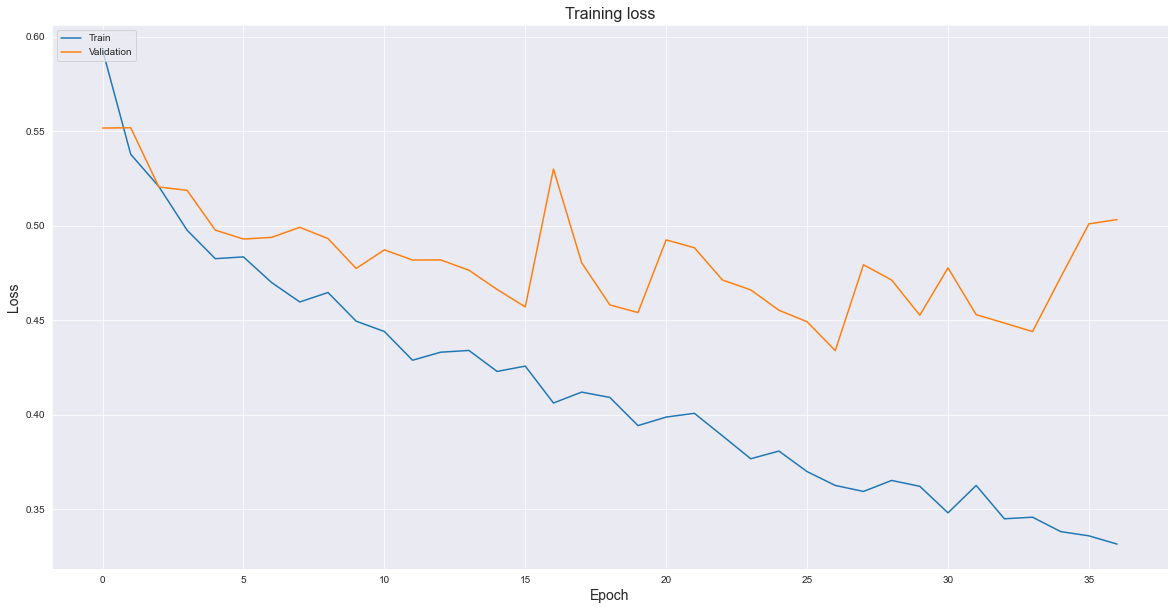

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.8717270325541532
validation dataset AUPRC: 0.8624750262641845
validation dataset acc: 0.7980636237897649
validation dataset F1: 0.7943661971830985
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---Fold2/5---
---Processing training data---


100%|██████████| 2640/2640 [00:26<00:00, 97.85it/s] 


---Processing validation data---


100%|██████████| 566/566 [00:05<00:00, 109.92it/s]


---Start training process---
Epoch 1/40
106/106 [==============================] - 30s 285ms/step - loss: 0.3906 - accuracy: 0.8213 - val_loss: 0.3557 - val_accuracy: 0.8479 - lr: 5.0000e-04
Epoch 2/40
106/106 [==============================] - 23s 214ms/step - loss: 0.3670 - accuracy: 0.8381 - val_loss: 0.3484 - val_accuracy: 0.8534 - lr: 5.0000e-04
Epoch 3/40
106/106 [==============================] - 23s 221ms/step - loss: 0.3529 - accuracy: 0.8455 - val_loss: 0.3489 - val_accuracy: 0.8451 - lr: 5.0000e-04
Epoch 4/40
106/106 [==============================] - 22s 206ms/step - loss: 0.3409 - accuracy: 0.8477 - val_loss: 0.3568 - val_accuracy: 0.8458 - lr: 5.0000e-04
Epoch 5/40
106/106 [==============================] - 21s 196ms/step - loss: 0.3393 - accuracy: 0.8508 - val_loss: 0.3534 - val_accuracy: 0.8389 - lr: 5.0000e-04
Epoch 6/40
106/106 [==============================] - 21s 196ms/step - loss: 0.3311 - accuracy: 0.8499 - val_loss: 0.3576 - val_accuracy: 0.8423 - lr: 5.0000e-04

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

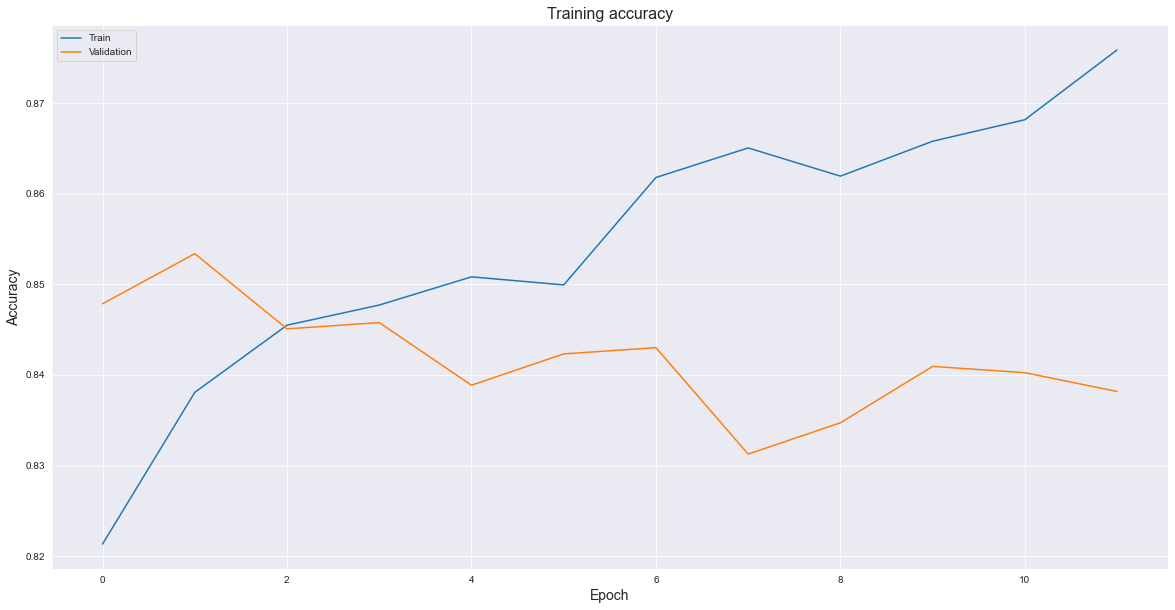

<Figure size 432x288 with 0 Axes>

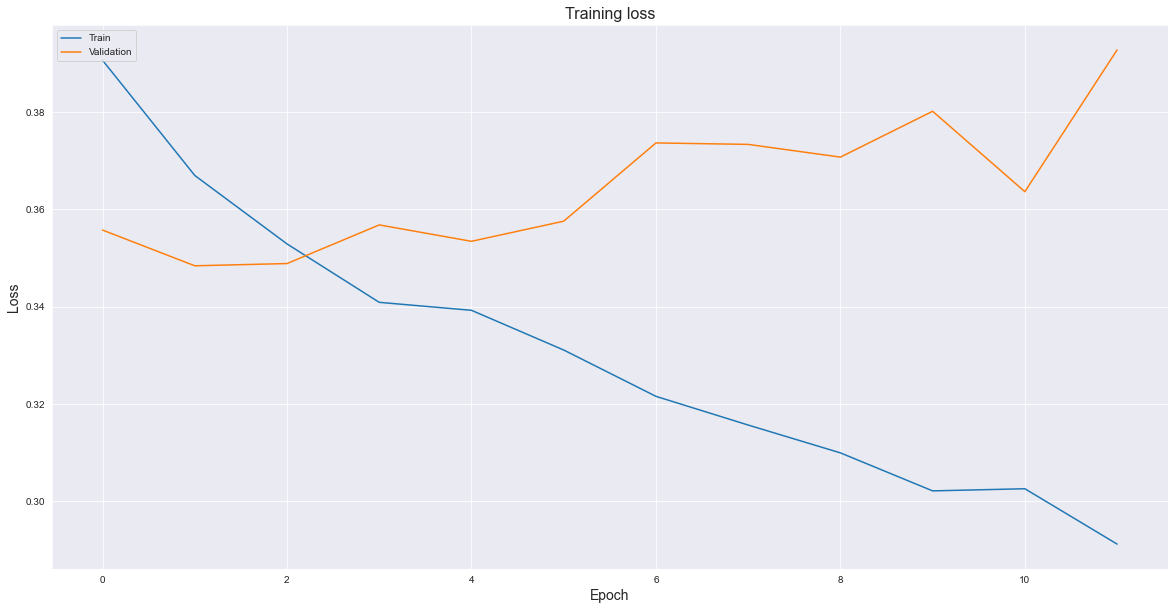

 Predicting on validation data...
validation dataset AUROC: 0.9160023645139259
validation dataset AUPRC: 0.9085405024187144
validation dataset acc: 0.8381742738589212
validation dataset F1: 0.8347457627118644
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---Fold3/5---
---Processing training data---


100%|██████████| 2640/2640 [00:23<00:00, 111.32it/s]


---Processing validation data---


100%|██████████| 566/566 [00:05<00:00, 107.67it/s]


---Start training process---
Epoch 1/40
106/106 [==============================] - 25s 240ms/step - loss: 0.3334 - accuracy: 0.8579 - val_loss: 0.3159 - val_accuracy: 0.8658 - lr: 2.5000e-04
Epoch 2/40
106/106 [==============================] - 24s 226ms/step - loss: 0.3093 - accuracy: 0.8670 - val_loss: 0.3122 - val_accuracy: 0.8665 - lr: 2.5000e-04
Epoch 3/40
106/106 [==============================] - 25s 234ms/step - loss: 0.2988 - accuracy: 0.8753 - val_loss: 0.3203 - val_accuracy: 0.8617 - lr: 2.5000e-04
Epoch 4/40
106/106 [==============================] - 25s 231ms/step - loss: 0.2883 - accuracy: 0.8762 - val_loss: 0.3249 - val_accuracy: 0.8568 - lr: 2.5000e-04
Epoch 5/40
106/106 [==============================] - 28s 260ms/step - loss: 0.2797 - accuracy: 0.8817 - val_loss: 0.3332 - val_accuracy: 0.8624 - lr: 2.5000e-04
Epoch 6/40
106/106 [==============================] - 27s 256ms/step - loss: 0.2702 - accuracy: 0.8898 - val_loss: 0.3529 - val_accuracy: 0.8610 - lr: 2.5000e-04

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

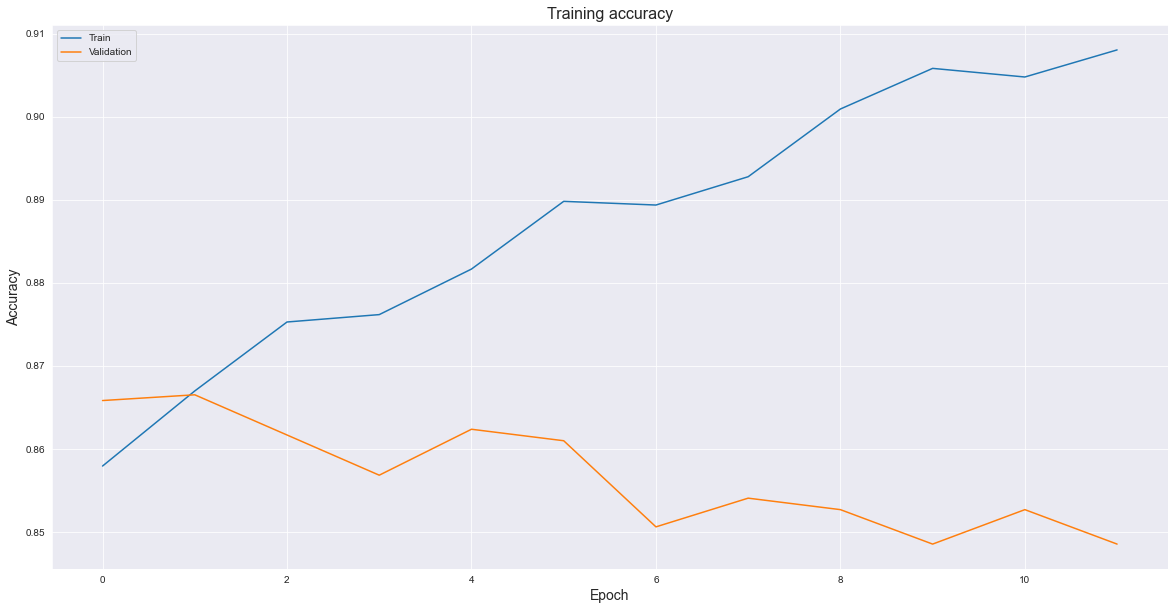

<Figure size 432x288 with 0 Axes>

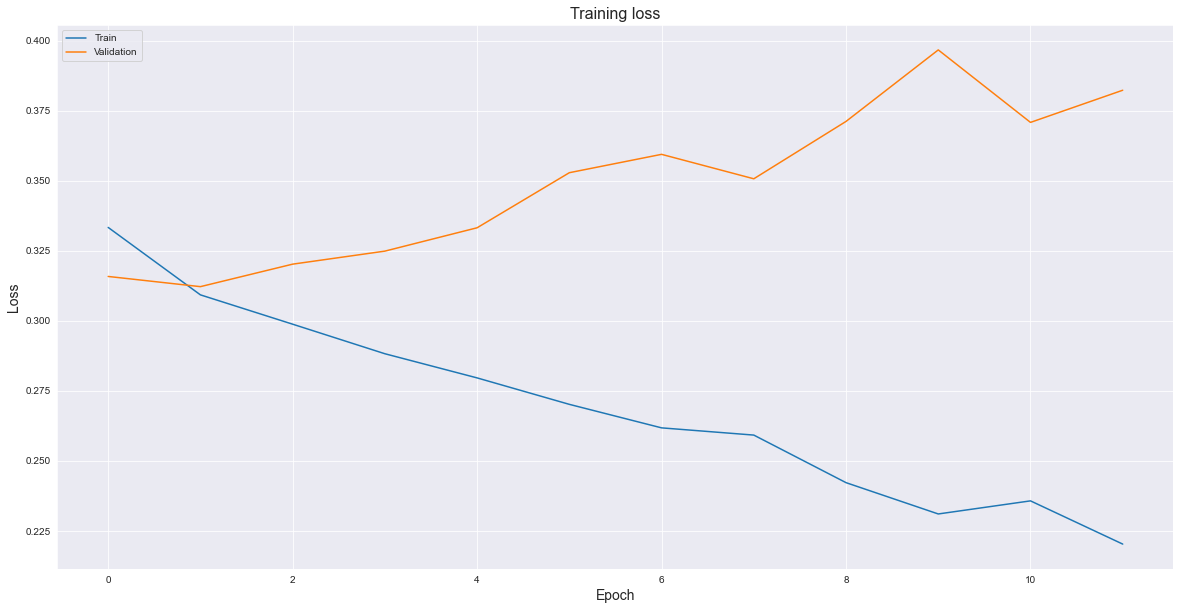

 Predicting on validation data...
validation dataset AUROC: 0.9215272158231129
validation dataset AUPRC: 0.914756606079089
validation dataset acc: 0.8485477178423236
validation dataset F1: 0.8509189925119129
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---Fold4/5---
---Processing training data---


100%|██████████| 2640/2640 [00:22<00:00, 116.30it/s]


---Processing validation data---


100%|██████████| 566/566 [00:04<00:00, 123.97it/s]


---Start training process---
Epoch 1/40
106/106 [==============================] - 21s 194ms/step - loss: 0.2923 - accuracy: 0.8786 - val_loss: 0.2959 - val_accuracy: 0.8790 - lr: 1.2500e-04
Epoch 2/40
106/106 [==============================] - 23s 214ms/step - loss: 0.2688 - accuracy: 0.8903 - val_loss: 0.2992 - val_accuracy: 0.8748 - lr: 1.2500e-04
Epoch 3/40
106/106 [==============================] - 22s 212ms/step - loss: 0.2555 - accuracy: 0.8941 - val_loss: 0.3054 - val_accuracy: 0.8672 - lr: 1.2500e-04
Epoch 4/40
106/106 [==============================] - 21s 200ms/step - loss: 0.2468 - accuracy: 0.9008 - val_loss: 0.3040 - val_accuracy: 0.8638 - lr: 1.2500e-04
Epoch 5/40
106/106 [==============================] - 21s 194ms/step - loss: 0.2376 - accuracy: 0.9026 - val_loss: 0.3020 - val_accuracy: 0.8755 - lr: 1.2500e-04
Epoch 6/40
106/106 [==============================] - 21s 198ms/step - loss: 0.2302 - accuracy: 0.9041 - val_loss: 0.3103 - val_accuracy: 0.8707 - lr: 1.2500e-04

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

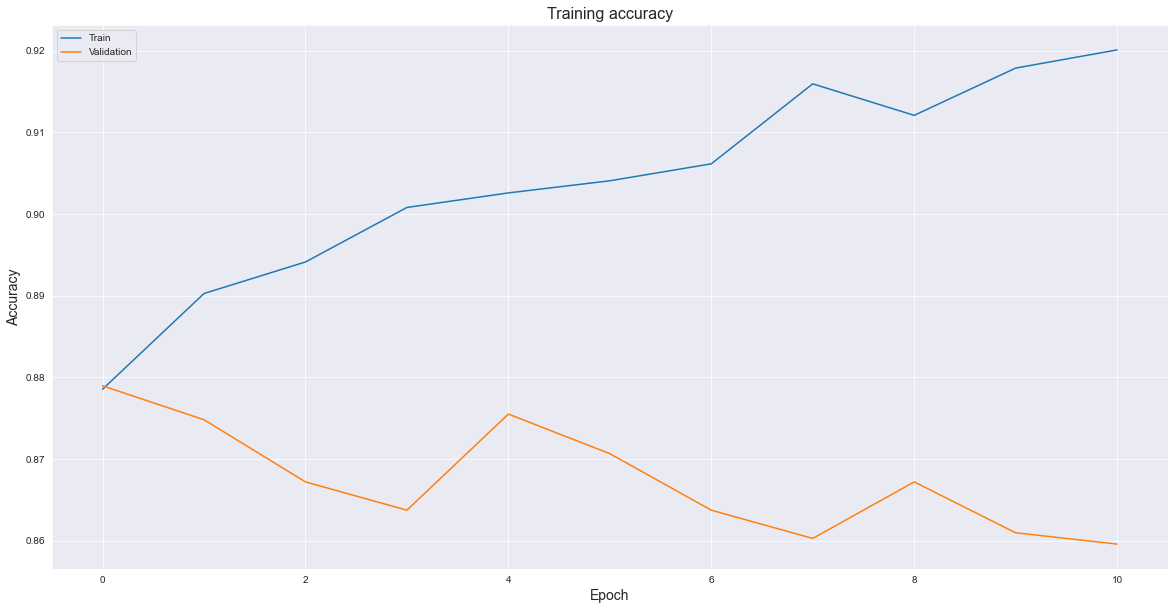

<Figure size 432x288 with 0 Axes>

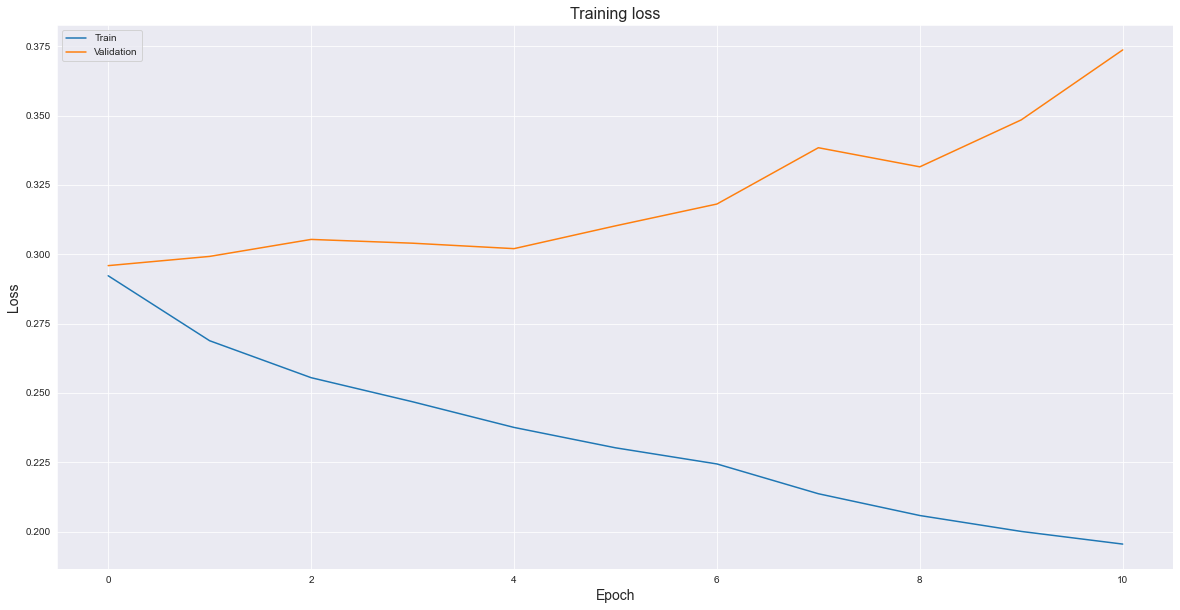

 Predicting on validation data...
validation dataset AUROC: 0.9334435242735719
validation dataset AUPRC: 0.9252229242537348
validation dataset acc: 0.859612724757953
validation dataset F1: 0.8619986403806933
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---Fold5/5---
---Processing training data---


100%|██████████| 2640/2640 [00:23<00:00, 113.50it/s]


---Processing validation data---


100%|██████████| 566/566 [00:04<00:00, 117.75it/s]


---Start training process---
Epoch 1/40
106/106 [==============================] - 21s 199ms/step - loss: 0.2623 - accuracy: 0.8940 - val_loss: 0.2493 - val_accuracy: 0.9046 - lr: 6.2500e-05
Epoch 2/40
106/106 [==============================] - 20s 192ms/step - loss: 0.2385 - accuracy: 0.9024 - val_loss: 0.2424 - val_accuracy: 0.9025 - lr: 6.2500e-05
Epoch 3/40
106/106 [==============================] - 20s 188ms/step - loss: 0.2283 - accuracy: 0.9090 - val_loss: 0.2513 - val_accuracy: 0.9080 - lr: 6.2500e-05
Epoch 4/40
106/106 [==============================] - 21s 197ms/step - loss: 0.2266 - accuracy: 0.9072 - val_loss: 0.2533 - val_accuracy: 0.9032 - lr: 6.2500e-05
Epoch 5/40
106/106 [==============================] - 21s 198ms/step - loss: 0.2152 - accuracy: 0.9146 - val_loss: 0.2471 - val_accuracy: 0.9025 - lr: 6.2500e-05
Epoch 6/40
106/106 [==============================] - 20s 191ms/step - loss: 0.2064 - accuracy: 0.9171 - val_loss: 0.2571 - val_accuracy: 0.8983 - lr: 6.2500e-05

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

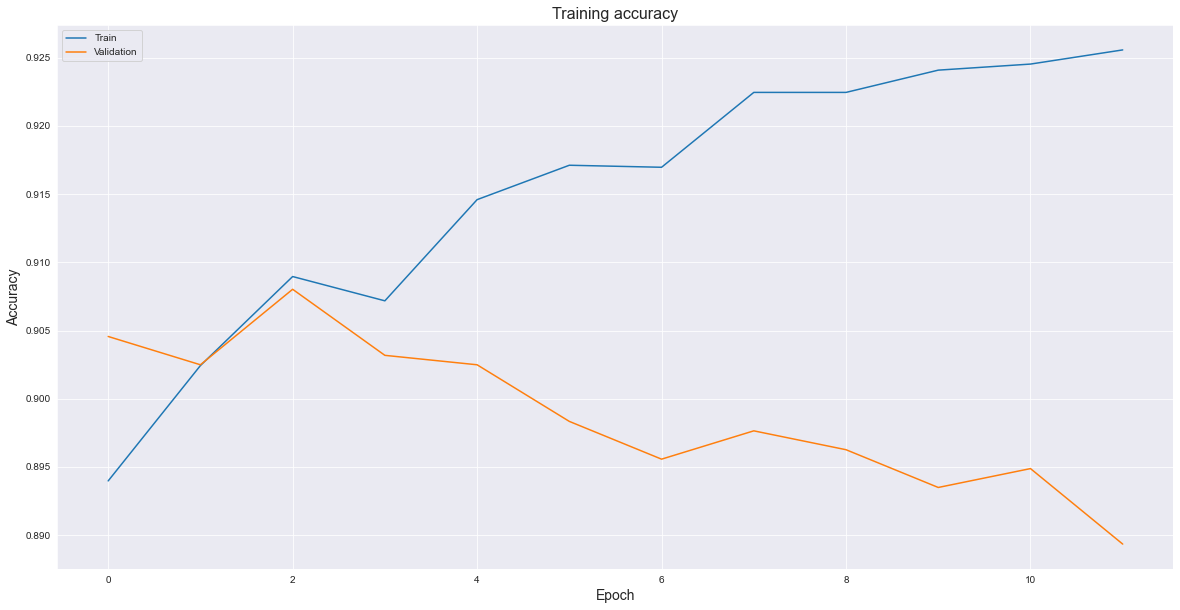

<Figure size 432x288 with 0 Axes>

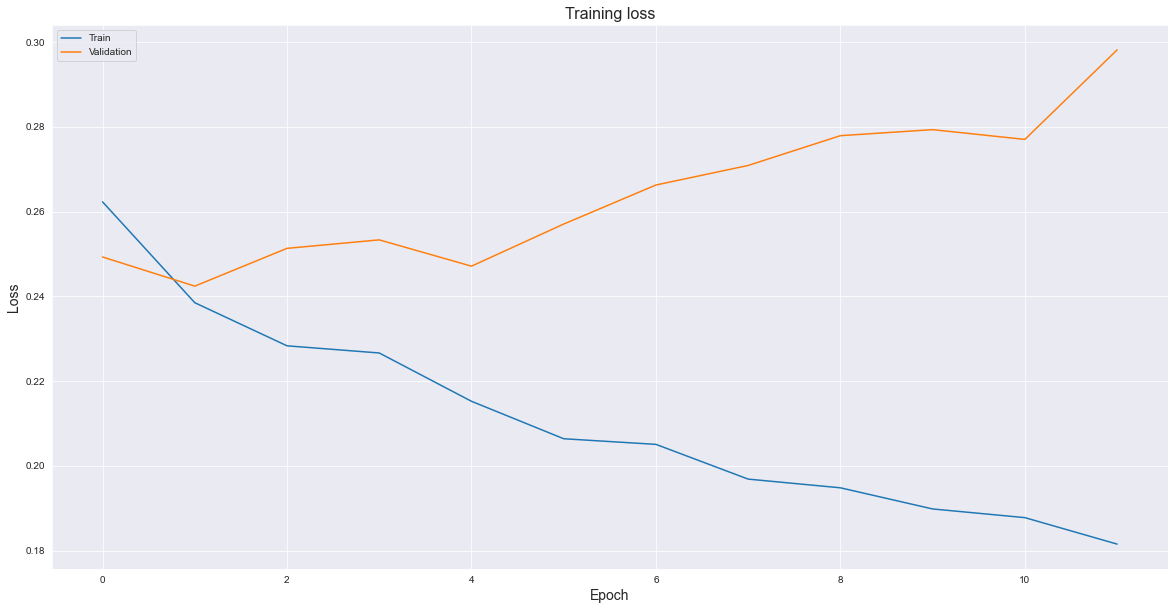

 Predicting on validation data...
validation dataset AUROC: 0.9535820664244761
validation dataset AUPRC: 0.9472341885779182
validation dataset acc: 0.8893499308437067
validation dataset F1: 0.892328398384926
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Averaged validation results:
 F1_score:0.8468715982344991
 Accuracy:0.8467496542185339
 AUROC:0.9192564407178481
 AUPRC:0.9116458495187283



<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

In [21]:
# define the optimized model from previous step
optimized_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128,return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
optimized_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

f1_list = []
accuracy_list = []
auprc_list = []
auroc_list = []
# 5-fold cross validation was implemented and five LSTM models were produced
sss = StratifiedShuffleSplit(n_splits=5, test_size = 3/17, random_state=np.random.seed(12306)) # val/train = 0.15/0.7
for (k, (train0_index, val0_index)), (k, (train1_index, val1_index)), (k, (train2_index, val2_index)), (k, (train3_index, val3_index))\
     in zip(enumerate(sss.split(train_nonsepsis_c, np.zeros(train_nonsepsis_c.shape))), enumerate(sss.split(train_sepsis_c, np.zeros(train_sepsis_c.shape))), enumerate(sss.split(train_nonsepsis_m, np.zeros(train_nonsepsis_m.shape))), enumerate(sss.split(train_sepsis_m, np.zeros(train_sepsis_m.shape)))):

    print('---Fold{}/5---'.format(k+1))

    print('---Processing training data---')
    # train_set_c = np.append((train_nonsepsis_c[train0_index])[:20], (train_sepsis_c[train1_index])[:20])
    train_set_c = np.append((train_nonsepsis_c[train0_index])[:2052], (train_sepsis_c[train1_index])[:2052])
    x_train_c, y_train_c = process_data_engineered(train_set_c, data_path_c, X_feature_engineered)

    # train_set_m = np.append((train_nonsepsis_m[train2_index][:13]), (train_sepsis_m[train3_index])[:13])
    train_set_m = np.append((train_nonsepsis_m[train2_index][:1320]), (train_sepsis_m[train3_index])[:1320])
    x_train_m, y_train_m = process_data_engineered(train_set_m, data_path_m, X_feature_engineered)

    x_train = np.concatenate((x_train_c, x_train_m))
    y_train = np.concatenate((y_train_c, y_train_m))


    print('---Processing validation data---')
    # val_set_c = np.append((train_nonsepsis_c[val0_index])[:4], (train_sepsis_c[val1_index][:4]))
    val_set_c = np.append((train_nonsepsis_c[val0_index])[:440], (train_sepsis_c[val1_index][:440]))
    x_val_c, y_val_c = process_data_engineered(val_set_c, data_path_c, X_feature_engineered)

    # val_set_m = np.append((train_nonsepsis_m[val2_index])[:2], (train_sepsis_m[val3_index])[:2])
    val_set_m = np.append((train_nonsepsis_m[val2_index])[:283], (train_sepsis_m[val3_index])[:283])
    x_val_m, y_val_m = process_data_engineered(val_set_m, data_path_m, X_feature_engineered)

    x_val = np.concatenate((x_val_c, x_val_m))
    y_val = np.concatenate((y_val_c, y_val_m))

    print('---Start training process---')

    # get the feature importance
    metrics = get_feature_importance(optimized_model, 64, x_train, y_train, x_val, y_val, k, X_feature_engineered, 'ed_wo_fs', 'EDWOFS')
    accuracy_list.append(metrics[0])
    f1_list.append(metrics[1])
    auroc_list.append(metrics[2])
    auprc_list.append(metrics[3])

def Average(lst):
    return sum(lst) / len(lst)

print('Averaged validation results:\n F1_score:{}\n Accuracy:{}\n AUROC:{}\n AUPRC:{}\n'.format(Average(f1_list),Average(accuracy_list), Average(auroc_list), Average(auprc_list)))

### Tune Hperparameter with FS

In [13]:
X_feature_engineered_fs = ['HR', 'SaO2', 'Temp', 'SBP', 'MAP', 
                        'DBP', 'RR', 'HCO3', 'PH', 'BUN', 
                        'Calcium', 'Chloride', 'Glucose','Potassium', 'PTT', 
                        'WBC', 'Platelet', 'age', 'HR_dev_2', 'Fever']
y_feature = ['sepsis']

### Train with FS

---Fold1/5---
---Processing training data---


100%|██████████| 2640/2640 [00:25<00:00, 104.53it/s]


---Processing validation data---


100%|██████████| 566/566 [00:05<00:00, 104.71it/s]


---Start training process---
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
106/106 [==============================] - ETA: 0s - loss: 0.6096 - accuracy: 0.6649WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fcda4b424d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
106/106 [==============================] - 33s 209ms/step - loss: 0.6096 - accuracy: 0.6649 - val_loss: 0

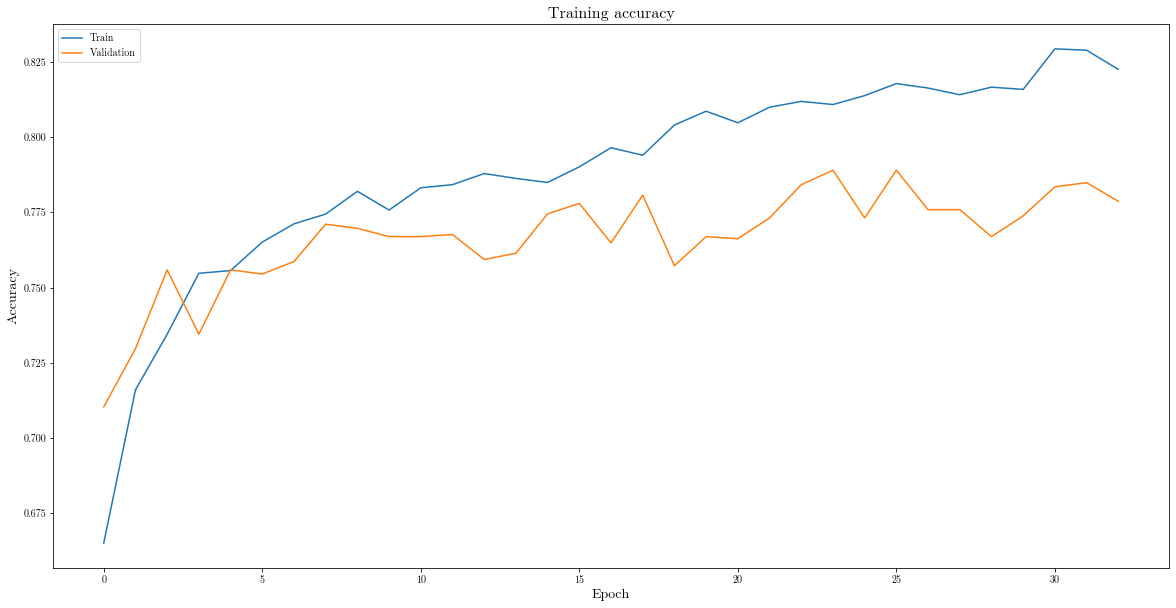

<Figure size 432x288 with 0 Axes>

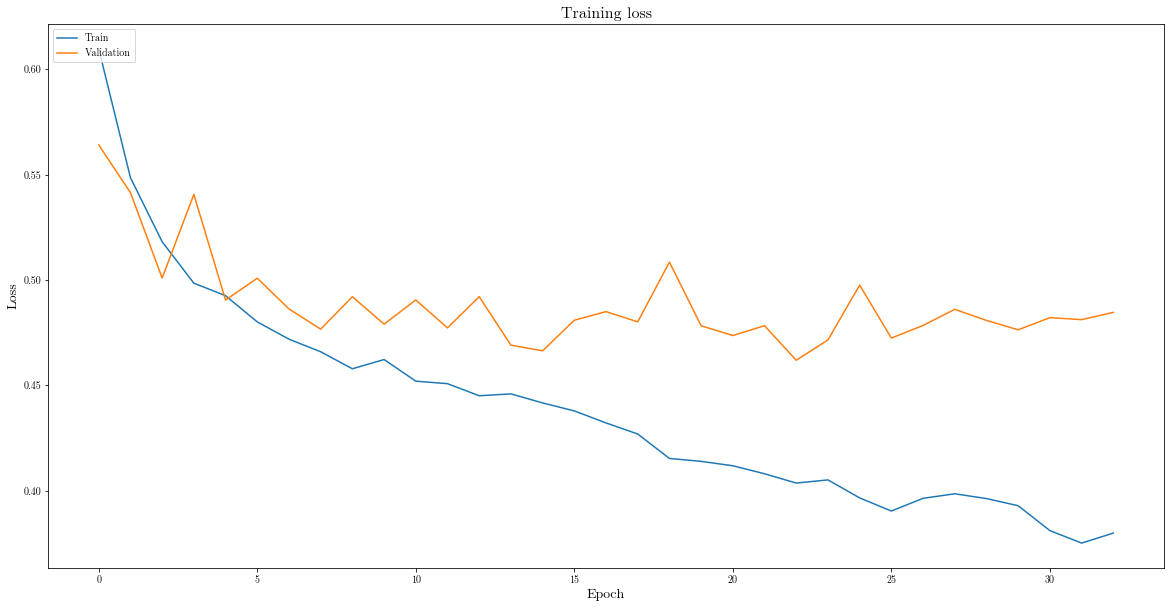

 Predicting on validation data...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
validation dataset AUROC: 0.8639849711800952
validation dataset AUPRC: 0.8576930516483866
validation dataset acc: 0.7786998616874136
validation dataset F1: 0.7707736389684814
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---Fold2/5---
---Processing training data---


100%|██████████| 2640/2640 [00:23<00:00, 114.24it/s]


---Processing validation data---


100%|██████████| 566/566 [00:04<00:00, 117.14it/s]


---Start training process---
Epoch 1/40
106/106 [==============================] - 19s 183ms/step - loss: 0.4091 - accuracy: 0.8167 - val_loss: 0.4139 - val_accuracy: 0.8084 - lr: 5.0000e-04
Epoch 2/40
106/106 [==============================] - 19s 180ms/step - loss: 0.3870 - accuracy: 0.8259 - val_loss: 0.4099 - val_accuracy: 0.8140 - lr: 5.0000e-04
Epoch 3/40
106/106 [==============================] - 19s 182ms/step - loss: 0.3742 - accuracy: 0.8330 - val_loss: 0.4163 - val_accuracy: 0.8126 - lr: 5.0000e-04
Epoch 4/40
106/106 [==============================] - 19s 180ms/step - loss: 0.3728 - accuracy: 0.8323 - val_loss: 0.4267 - val_accuracy: 0.8091 - lr: 5.0000e-04
Epoch 5/40
106/106 [==============================] - 19s 180ms/step - loss: 0.3670 - accuracy: 0.8324 - val_loss: 0.4106 - val_accuracy: 0.8105 - lr: 5.0000e-04
Epoch 6/40
106/106 [==============================] - 19s 180ms/step - loss: 0.3554 - accuracy: 0.8391 - val_loss: 0.4193 - val_accuracy: 0.7988 - lr: 5.0000e-04

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

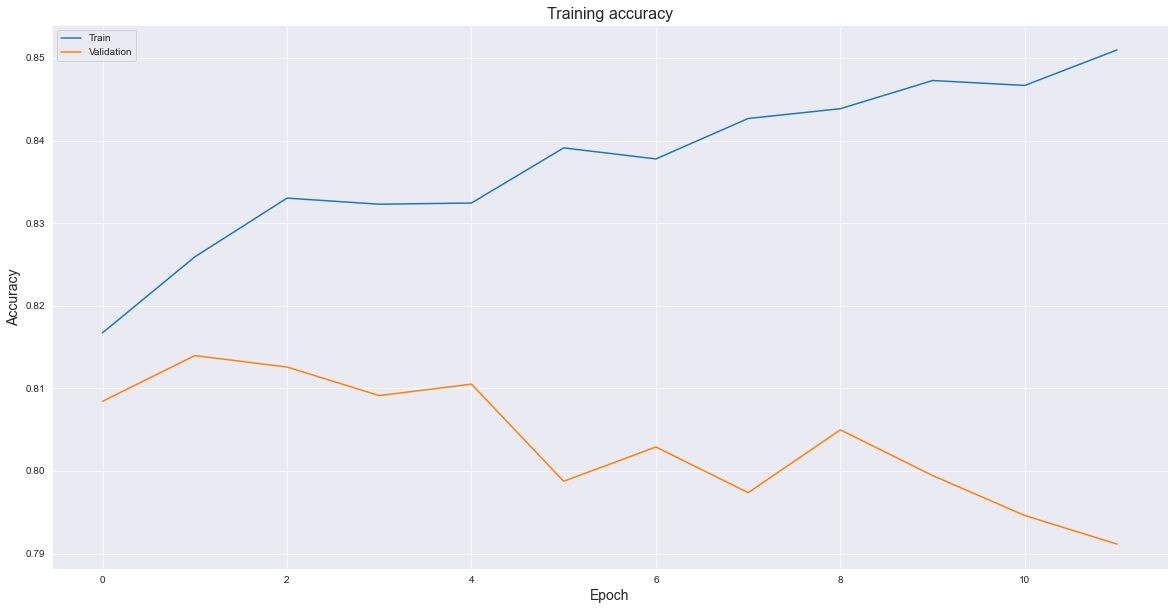

<Figure size 432x288 with 0 Axes>

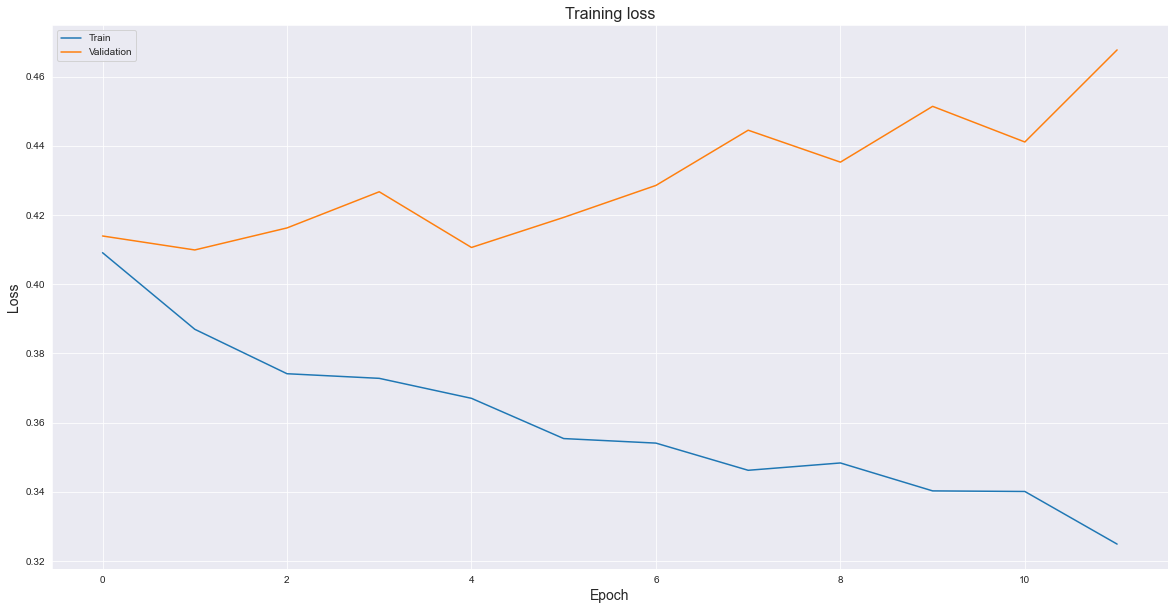

 Predicting on validation data...
validation dataset AUROC: 0.8774546658019738
validation dataset AUPRC: 0.8744283446541463
validation dataset acc: 0.7911479944674965
validation dataset F1: 0.8038961038961038
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---Fold3/5---
---Processing training data---


100%|██████████| 2640/2640 [00:23<00:00, 112.26it/s]


---Processing validation data---


100%|██████████| 566/566 [00:04<00:00, 115.86it/s]


---Start training process---
Epoch 1/40
106/106 [==============================] - 19s 184ms/step - loss: 0.3604 - accuracy: 0.8421 - val_loss: 0.3741 - val_accuracy: 0.8271 - lr: 2.5000e-04
Epoch 2/40
106/106 [==============================] - 20s 187ms/step - loss: 0.3334 - accuracy: 0.8493 - val_loss: 0.3725 - val_accuracy: 0.8347 - lr: 2.5000e-04
Epoch 3/40
106/106 [==============================] - 20s 184ms/step - loss: 0.3218 - accuracy: 0.8571 - val_loss: 0.3736 - val_accuracy: 0.8271 - lr: 2.5000e-04
Epoch 4/40
106/106 [==============================] - 19s 183ms/step - loss: 0.3077 - accuracy: 0.8624 - val_loss: 0.3915 - val_accuracy: 0.8306 - lr: 2.5000e-04
Epoch 5/40
106/106 [==============================] - 19s 182ms/step - loss: 0.3080 - accuracy: 0.8646 - val_loss: 0.3993 - val_accuracy: 0.8202 - lr: 2.5000e-04
Epoch 6/40
106/106 [==============================] - 20s 184ms/step - loss: 0.2971 - accuracy: 0.8685 - val_loss: 0.4033 - val_accuracy: 0.8202 - lr: 2.5000e-04

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

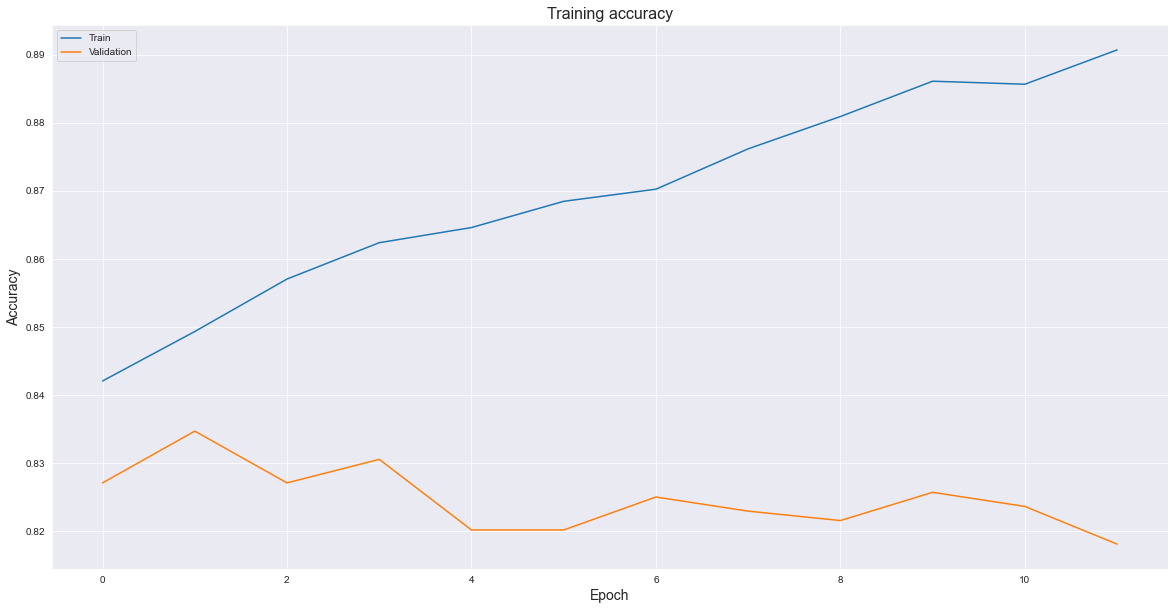

<Figure size 432x288 with 0 Axes>

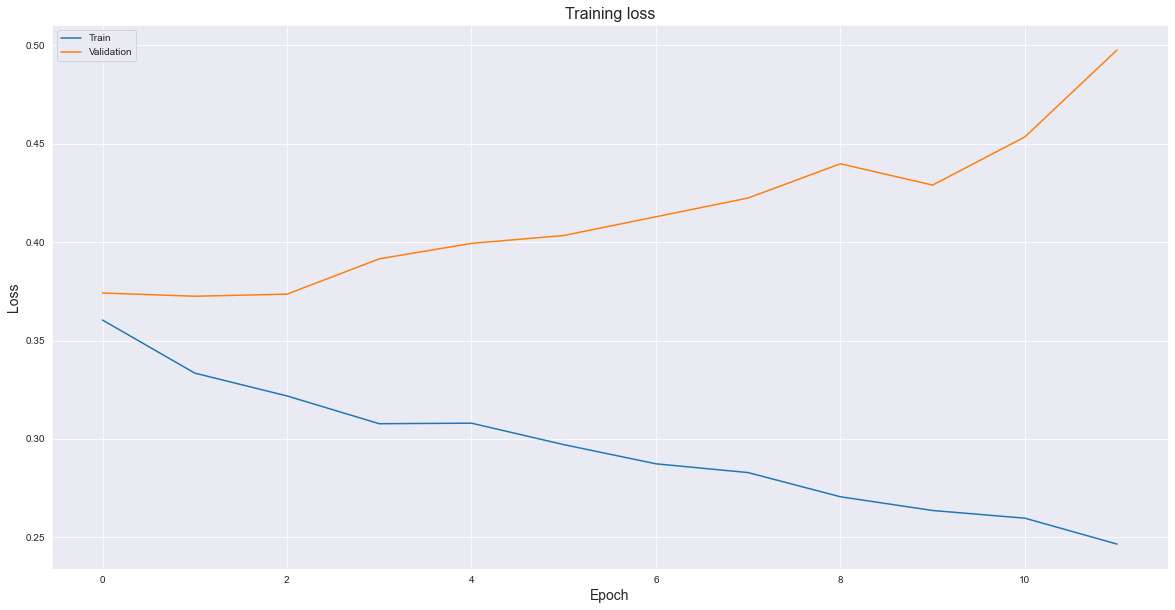

 Predicting on validation data...
validation dataset AUROC: 0.8912687071120982
validation dataset AUPRC: 0.8664600139494096
validation dataset acc: 0.818118948824343
validation dataset F1: 0.8231338264963013
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---Fold4/5---
---Processing training data---


100%|██████████| 2640/2640 [00:20<00:00, 126.72it/s]


---Processing validation data---


100%|██████████| 566/566 [00:04<00:00, 122.62it/s]


---Start training process---
Epoch 1/40
106/106 [==============================] - 20s 188ms/step - loss: 0.3429 - accuracy: 0.8485 - val_loss: 0.2930 - val_accuracy: 0.8658 - lr: 1.2500e-04
Epoch 2/40
106/106 [==============================] - 19s 182ms/step - loss: 0.3097 - accuracy: 0.8640 - val_loss: 0.2934 - val_accuracy: 0.8672 - lr: 1.2500e-04
Epoch 3/40
106/106 [==============================] - 19s 182ms/step - loss: 0.2984 - accuracy: 0.8663 - val_loss: 0.3043 - val_accuracy: 0.8610 - lr: 1.2500e-04
Epoch 4/40
106/106 [==============================] - 19s 180ms/step - loss: 0.2880 - accuracy: 0.8741 - val_loss: 0.2970 - val_accuracy: 0.8721 - lr: 1.2500e-04
Epoch 5/40
106/106 [==============================] - 19s 181ms/step - loss: 0.2793 - accuracy: 0.8756 - val_loss: 0.2993 - val_accuracy: 0.8665 - lr: 1.2500e-04
Epoch 6/40
106/106 [==============================] - 19s 183ms/step - loss: 0.2711 - accuracy: 0.8809 - val_loss: 0.3097 - val_accuracy: 0.8624 - lr: 1.2500e-04

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

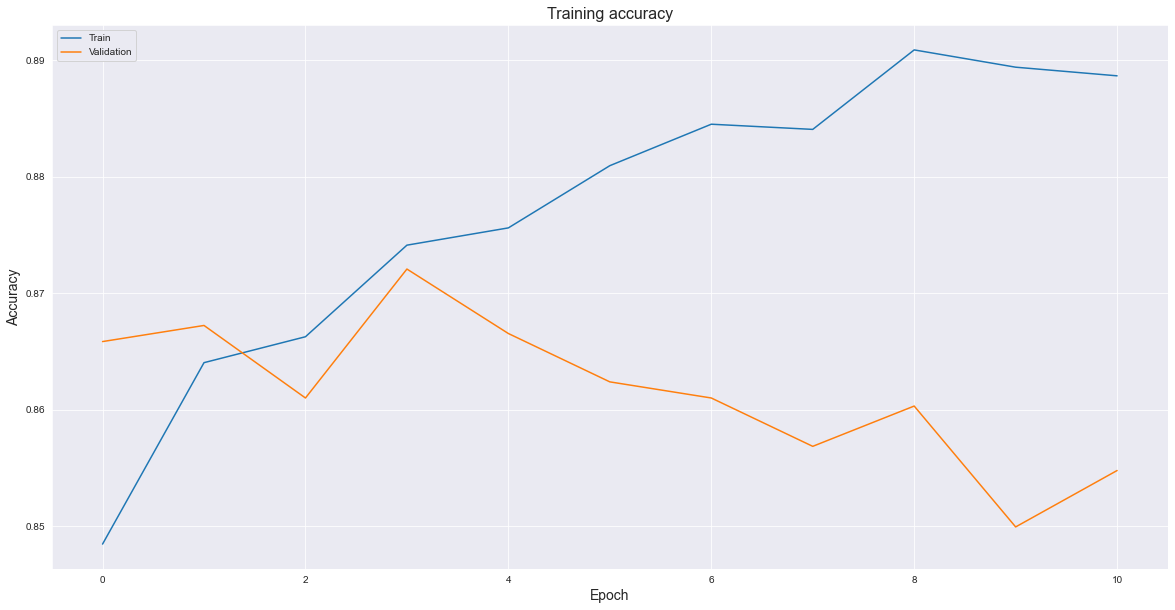

<Figure size 432x288 with 0 Axes>

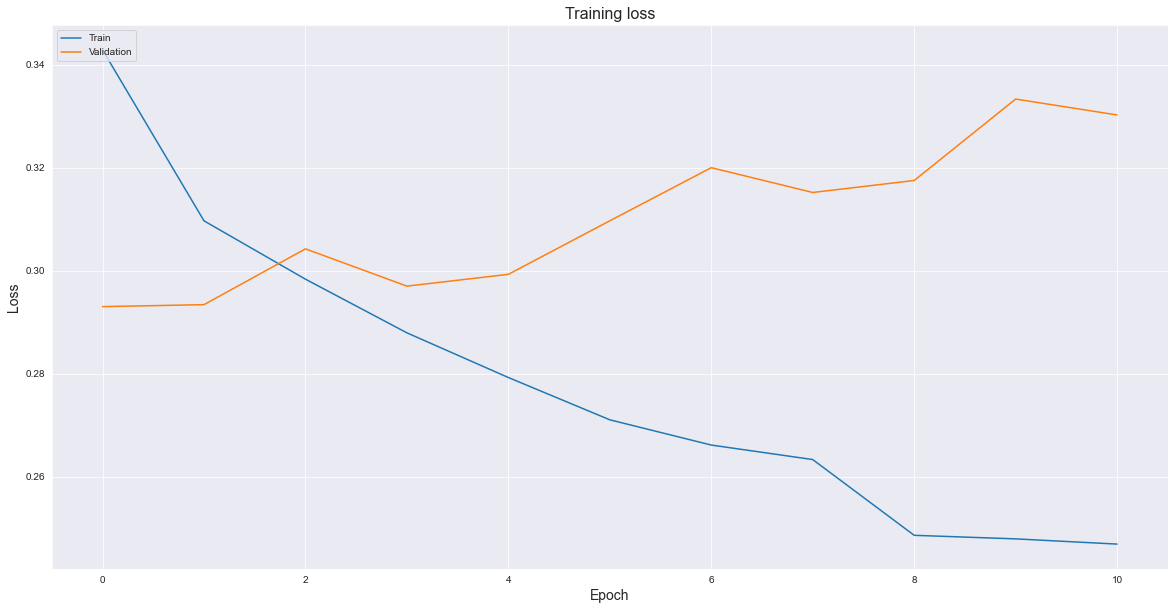

 Predicting on validation data...
validation dataset AUROC: 0.9365636878765097
validation dataset AUPRC: 0.9345556896879245
validation dataset acc: 0.8547717842323651
validation dataset F1: 0.8553719008264463
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---Fold5/5---
---Processing training data---


100%|██████████| 2640/2640 [00:19<00:00, 134.55it/s]


---Processing validation data---


100%|██████████| 566/566 [00:05<00:00, 101.15it/s]


---Start training process---
Epoch 1/40
106/106 [==============================] - 21s 199ms/step - loss: 0.2993 - accuracy: 0.8735 - val_loss: 0.2689 - val_accuracy: 0.8776 - lr: 6.2500e-05
Epoch 2/40
106/106 [==============================] - 19s 181ms/step - loss: 0.2810 - accuracy: 0.8792 - val_loss: 0.2698 - val_accuracy: 0.8707 - lr: 6.2500e-05
Epoch 3/40
106/106 [==============================] - 19s 181ms/step - loss: 0.2696 - accuracy: 0.8854 - val_loss: 0.2803 - val_accuracy: 0.8700 - lr: 6.2500e-05
Epoch 4/40
106/106 [==============================] - 19s 180ms/step - loss: 0.2695 - accuracy: 0.8872 - val_loss: 0.2760 - val_accuracy: 0.8672 - lr: 6.2500e-05
Epoch 5/40
106/106 [==============================] - 19s 182ms/step - loss: 0.2587 - accuracy: 0.8888 - val_loss: 0.2814 - val_accuracy: 0.8665 - lr: 6.2500e-05
Epoch 6/40
106/106 [==============================] - 19s 183ms/step - loss: 0.2582 - accuracy: 0.8901 - val_loss: 0.2862 - val_accuracy: 0.8686 - lr: 6.2500e-05

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

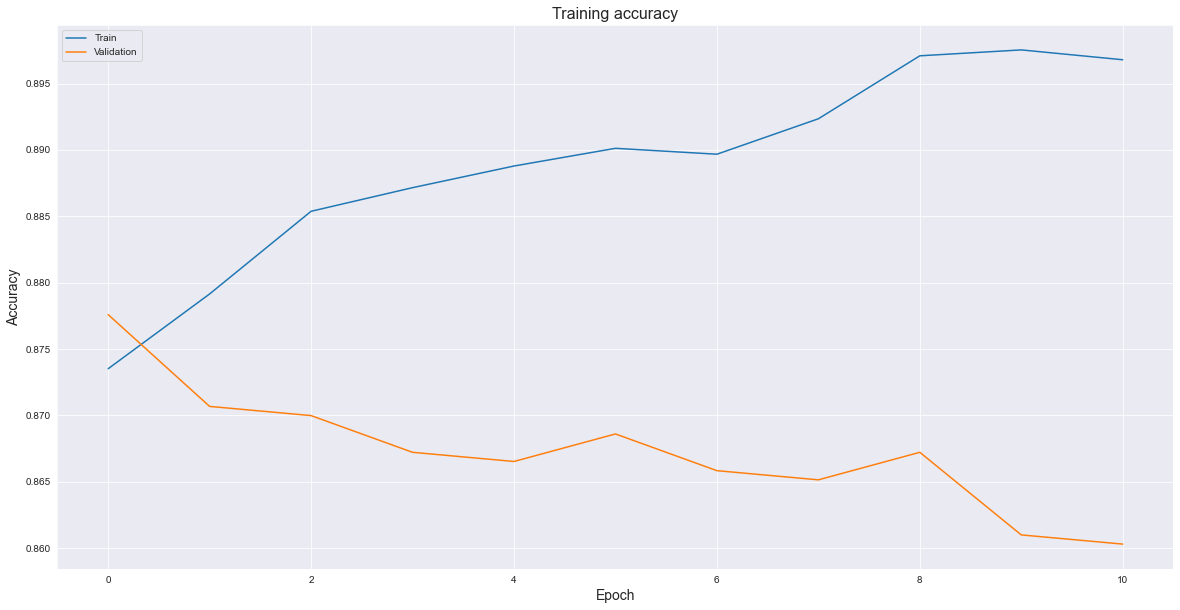

<Figure size 432x288 with 0 Axes>

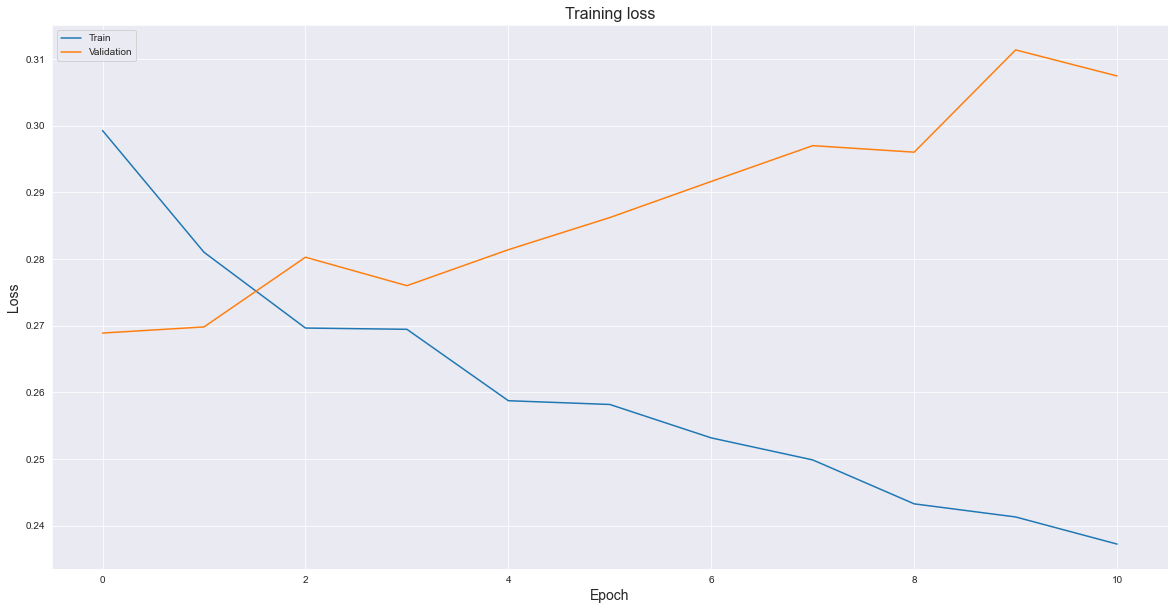

 Predicting on validation data...
validation dataset AUROC: 0.9440704456802664
validation dataset AUPRC: 0.9379374138933347
validation dataset acc: 0.8603042876901799
validation dataset F1: 0.8629579375848032
 Computing LSTM feature importance...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Averaged validation results:
 F1_score:0.8232266815544271
 Accuracy:0.8206085753803596
 AUROC:0.9026684955301887
 AUPRC:0.8942149027666403



<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

In [14]:
# define the optimized model from previous step
optimized_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128,return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
optimized_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

f1_list = []
accuracy_list = []
auprc_list = []
auroc_list = []
# 5-fold cross validation was implemented and five LSTM models were produced
sss = StratifiedShuffleSplit(n_splits=5, test_size = 3/17, random_state=np.random.seed(12306)) # val/train = 0.15/0.7
for (k, (train0_index, val0_index)), (k, (train1_index, val1_index)), (k, (train2_index, val2_index)), (k, (train3_index, val3_index))\
     in zip(enumerate(sss.split(train_nonsepsis_c, np.zeros(train_nonsepsis_c.shape))), enumerate(sss.split(train_sepsis_c, np.zeros(train_sepsis_c.shape))), enumerate(sss.split(train_nonsepsis_m, np.zeros(train_nonsepsis_m.shape))), enumerate(sss.split(train_sepsis_m, np.zeros(train_sepsis_m.shape)))):

    print('---Fold{}/5---'.format(k+1))

    print('---Processing training data---')
    # train_set_c = np.append((train_nonsepsis_c[train0_index])[:20], (train_sepsis_c[train1_index])[:20])
    train_set_c = np.append((train_nonsepsis_c[train0_index])[:2052], (train_sepsis_c[train1_index])[:2052])
    x_train_c, y_train_c = process_data_engineered(train_set_c, data_path_c, X_feature_engineered_fs)

    # train_set_m = np.append((train_nonsepsis_m[train2_index][:13]), (train_sepsis_m[train3_index])[:13])
    train_set_m = np.append((train_nonsepsis_m[train2_index][:1320]), (train_sepsis_m[train3_index])[:1320])
    x_train_m, y_train_m = process_data_engineered(train_set_m, data_path_m, X_feature_engineered_fs)

    x_train = np.concatenate((x_train_c, x_train_m))
    y_train = np.concatenate((y_train_c, y_train_m))


    print('---Processing validation data---')
    # val_set_c = np.append((train_nonsepsis_c[val0_index])[:4], (train_sepsis_c[val1_index][:4]))
    val_set_c = np.append((train_nonsepsis_c[val0_index])[:440], (train_sepsis_c[val1_index][:440]))
    x_val_c, y_val_c = process_data_engineered(val_set_c, data_path_c, X_feature_engineered_fs)

    # val_set_m = np.append((train_nonsepsis_m[val2_index])[:2], (train_sepsis_m[val3_index])[:2])
    val_set_m = np.append((train_nonsepsis_m[val2_index])[:283], (train_sepsis_m[val3_index])[:283])
    x_val_m, y_val_m = process_data_engineered(val_set_m, data_path_m, X_feature_engineered_fs)

    x_val = np.concatenate((x_val_c, x_val_m))
    y_val = np.concatenate((y_val_c, y_val_m))

    print('---Start training process---')

    # get the feature importance
    metrics = get_feature_importance(optimized_model, 64, x_train, y_train, x_val, y_val, k, X_feature_engineered_fs, 'ed_w_fs', 'EDWFS')
    accuracy_list.append(metrics[0])
    f1_list.append(metrics[1])
    auroc_list.append(metrics[2])
    auprc_list.append(metrics[3])

def Average(lst):
    return sum(lst) / len(lst)

print('Averaged validation results:\n F1_score:{}\n Accuracy:{}\n AUROC:{}\n AUPRC:{}\n'.format(Average(f1_list),Average(accuracy_list), Average(auroc_list), Average(auprc_list)))

## Performance on Test Data

### Score Function


In [19]:
# This file contains functions for evaluating algorithms for the 2019 PhysioNet/
# CinC Challenge. You can run it as follows:

################################################################################

# The evaluate_scores function computes a normalized utility score for a cohort
# of patients along with several traditional scoring metrics.
#
# Inputs:
#   'label_directory' is a directory of pipe-delimited text files containing a
#   binary vector of labels for whether a patient is not septic (0) or septic
#   (1) for each time interval.
#
#   'prediction_directory' is a directory of pipe-delimited text files, where
#   the first column of the file gives the predicted probability that the
#   patient is septic at each time, and the second column of the file is a
#   binarized version of this vector. Note that there must be a prediction for
#   every label.
#
# Outputs:
#   'auroc' is the area under the receiver operating characteristic curve
#   (AUROC).
#
#   'auprc' is the area under the precision recall curve (AUPRC).
#
#   'accuracy' is accuracy.
#
#   'f_measure' is F-measure.
#
#   'normalized_observed_utility' is a normalized utility-based measure that we
#   created for the Challenge. This score is normalized so that a perfect score
#   is 1 and no positive predictions is 0.
#
# Example:
#   Omitted due to length. See the below examples.

import numpy as np, os, os.path, sys, warnings

def evaluate_sepsis_score(label_directory, prediction_directory):
    # Set parameters.
    label_header       = 'sepsis'
    prediction_header  = 'PredictedLabel'
    probability_header = 'PredictedProbability'

    dt_early   = -12
    dt_optimal = -6
    dt_late    = 3

    max_u_tp = 1
    min_u_fn = -2
    u_fp     = -0.05
    u_tn     = 0

    # Find label and prediction files.
    label_files = []
    for f in os.listdir(label_directory):
        g = os.path.join(label_directory, f)
        if os.path.isfile(g) and not f.lower().startswith('.') and f.lower().endswith('csv'):
            label_files.append(g)
    label_files = sorted(label_files)

    prediction_files = []
    for f in os.listdir(prediction_directory):
        g = os.path.join(prediction_directory, f)
        if os.path.isfile(g) and not f.lower().startswith('.') and f.lower().endswith('csv'):
            prediction_files.append(g)
    prediction_files = sorted(prediction_files)

    if len(label_files) != len(prediction_files):
        raise Exception('Numbers of label and prediction files must be the same.')

    # Load labels and predictions.
    num_files            = len(label_files)
    cohort_labels        = []
    cohort_predictions   = []
    cohort_probabilities = []

    for k in range(num_files):
        labels        = load_column(label_files[k], label_header, ',')
        predictions   = load_column(prediction_files[k], prediction_header, ',')
        probabilities = load_column(prediction_files[k], probability_header, ',')

        # Check labels and predictions for errors.
        if not (len(labels) == len(predictions) and len(predictions) == len(probabilities)):
            raise Exception('Numbers of labels and predictions for a file must be the same.')

        num_rows = len(labels)

        for i in range(num_rows):
            if labels[i] not in (0, 1):
                raise Exception('Labels must satisfy label == 0 or label == 1.')

            if predictions[i] not in (0, 1):
                raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

            if not 0 <= probabilities[i] <= 1:
                warnings.warn('Probabilities do not satisfy 0 <= probability <= 1.')

        if 0 < np.sum(predictions) < num_rows:
            min_probability_positive = np.min(probabilities[predictions == 1])
            max_probability_negative = np.max(probabilities[predictions == 0])

            if min_probability_positive <= max_probability_negative:
                warnings.warn('Predictions are inconsistent with probabilities, i.e., a positive prediction has a lower (or equal) probability than a negative prediction.')

        # Record labels and predictions.
        cohort_labels.append(labels)
        cohort_predictions.append(predictions)
        cohort_probabilities.append(probabilities)

    # Compute AUC, accuracy, and F-measure.
    labels        = np.concatenate(cohort_labels)
    predictions   = np.concatenate(cohort_predictions)
    probabilities = np.concatenate(cohort_probabilities)

    auroc, auprc        = compute_auc(labels, probabilities)
    accuracy, f_measure = compute_accuracy_f_measure(labels, predictions)

    # Compute utility.
    observed_utilities = np.zeros(num_files)
    best_utilities     = np.zeros(num_files)
    worst_utilities    = np.zeros(num_files)
    inaction_utilities = np.zeros(num_files)

    for k in range(num_files):
        labels = cohort_labels[k]
        num_rows          = len(labels)
        observed_predictions = cohort_predictions[k]
        best_predictions     = np.zeros(num_rows)
        worst_predictions    = np.zeros(num_rows)
        inaction_predictions = np.zeros(num_rows)

        if np.any(labels):
            t_sepsis = np.argmax(labels) - dt_optimal
            best_predictions[max(0, t_sepsis + dt_early) : min(t_sepsis + dt_late + 1, num_rows)] = 1
        worst_predictions = 1 - best_predictions

        observed_utilities[k] = compute_prediction_utility(labels, observed_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        best_utilities[k]     = compute_prediction_utility(labels, best_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        worst_utilities[k]    = compute_prediction_utility(labels, worst_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        inaction_utilities[k] = compute_prediction_utility(labels, inaction_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)

    unnormalized_observed_utility = np.sum(observed_utilities)
    unnormalized__utility     = np.sum(best_utilities)
    unnormalized_worst_utility    = np.sum(worst_utilities)
    unnormalized_inaction_utility = np.sum(inaction_utilities)

    normalized_observed_utility = (unnormalized_observed_utility - unnormalized_inaction_utility) / (unnormalized__utility - unnormalized_inaction_utility)

    return auroc, auprc, accuracy, f_measure, normalized_observed_utility

# The load_column function loads a column from a table.
#
# Inputs:
#   'filename' is a string containing a filename.
#
#   'header' is a string containing a header.
#
# Outputs:
#   'column' is a vector containing a column from the file with the given
#   header.
#
# Example:
#   Omitted.

def load_column(filename, header, delimiter):
    column = []
    with open(filename, 'r') as f:
        for i, l in enumerate(f):
            arrs = l.strip().split(delimiter)
            if i == 0:
                try:
                    j = arrs.index(header)
                except:
                    raise Exception('{} must contain column with header {} containing numerical entries.'.format(filename, header))
            else:
                if len(arrs[j]):
                    column.append(float(arrs[j]))
    return np.array(column)

# The compute_auc function computes AUROC and AUPRC as well as other summary
# statistics (TP, FP, FN, TN, tpr_, TNR, PPV, NPV, etc.) that can be exposed
# from this function.
#
# Inputs:
#   'labels' is a binary vector, where labels[i] == 0 if the patient is not
#   labeled as septic at time i and labels[i] == 1 if the patient is labeled as
#   septic at time i.
#
#   'predictions' is a probability vector, where predictions[i] gives the
#   predicted probability that the patient is septic at time i.  Note that there
#   must be a prediction for every label, i.e, len(labels) ==
#   len(predictions).
#
# Outputs:
#   'auroc' is a scalar that gives the AUROC of the algorithm using its
#   predicted probabilities, where specificity is interpolated for intermediate
#   sensitivity values.
#
#   'auprc' is a scalar that gives the AUPRC of the algorithm using its
#   predicted probabilities, where precision is a piecewise constant function of
#   recall.
#
# Example:
#   In [1]: labels = [0, 0, 0, 0, 1, 1]
#   In [2]: predictions = [0.3, 0.4, 0.6, 0.7, 0.8, 0.8]
#   In [3]: auroc, auprc = compute_auc(labels, predictions)
#   In [4]: auroc
#   Out[4]: 1.0
#   In [5]: auprc
#   Out[5]: 1.0

def compute_auc(labels, predictions, check_errors=True):
    # Check inputs for errors.
    if check_errors:
        if len(predictions) != len(labels):
            raise Exception('Numbers of predictions and labels must be the same.')

        for label in labels:
            if not label in (0, 1):
                raise Exception('Labels must satisfy label == 0 or label == 1.')

        for prediction in predictions:
            if not 0 <= prediction <= 1:
                warnings.warn('Predictions do not satisfy 0 <= prediction <= 1.')

    # Find prediction thresholds.
    thresholds = np.unique(predictions)[::-1]
    if thresholds[0] != 1:
        thresholds = np.insert(thresholds, 0, 1)
    if thresholds[-1] == 0:
        thresholds = thresholds[:-1]

    n = len(labels)
    m = len(thresholds)

    # Populate contingency table across prediction thresholds.
    tp = np.zeros(m)
    fp = np.zeros(m)
    fn = np.zeros(m)
    tn = np.zeros(m)

    # Find indices that sort the predicted probabilities from largest to
    # smallest.
    idx = np.argsort(predictions)[::-1]

    i = 0
    for j in range(m):
        # Initialize contingency table for j-th prediction threshold.
        if j == 0:
            tp[j] = 0
            fp[j] = 0
            fn[j] = np.sum(labels)
            tn[j] = n - fn[j]
        else:
            tp[j] = tp[j - 1]
            fp[j] = fp[j - 1]
            fn[j] = fn[j - 1]
            tn[j] = tn[j - 1]

        # Update contingency table for i-th largest predicted probability.
        while i < n and predictions[idx[i]] >= thresholds[j]:
            if labels[idx[i]]:
                tp[j] += 1
                fn[j] -= 1
            else:
                fp[j] += 1
                tn[j] -= 1
            i += 1

    # Summarize contingency table.
    tpr_ = np.zeros(m)
    tnr = np.zeros(m)
    ppv = np.zeros(m)
    npv = np.zeros(m)

    for j in range(m):
        if tp[j] + fn[j]:
            tpr_[j] = tp[j] / (tp[j] + fn[j])
        else:
            tpr_[j] = 1
        if fp[j] + tn[j]:
            tnr[j] = tn[j] / (fp[j] + tn[j])
        else:
            tnr[j] = 1
        if tp[j] + fp[j]:
            ppv[j] = tp[j] / (tp[j] + fp[j])
        else:
            ppv[j] = 1
        if fn[j] + tn[j]:
            npv[j] = tn[j] / (fn[j] + tn[j])
        else:
            npv[j] = 1

    # Compute AUROC as the area under a piecewise linear function with tpr_ /
    # sensitivity (x-axis) and TNR / specificity (y-axis) and AUPRC as the area
    # under a piecewise constant with tpr_ / recall (x-axis) and PPV / precision
    # (y-axis).
    auroc = 0
    auprc = 0
    for j in range(m-1):
        auroc += 0.5 * (tpr_[j + 1] - tpr_[j]) * (tnr[j + 1] + tnr[j])
        auprc += (tpr_[j + 1] - tpr_[j]) * ppv[j + 1]

    return auroc, auprc

# The compute_accuracy_f_measure function computes the accuracy and F-measure
# for a patient.
#
# Inputs:
#   'labels' is a binary vector, where labels[i] == 0 if the patient is not
#   labeled as septic at time i and labels[i] == 1 if the patient is labeled as
#   septic at time i.
#
#   'predictions' is a binary vector, where predictions[i] == 0 if the patient
#   is not predicted to be septic at time i and predictions[i] == 1 if the
#   patient is predicted to be septic at time i.  Note that there must be a
#   prediction for every label, i.e, len(labels) == len(predictions).
#
# Output:
#   'accuracy' is a scalar that gives the accuracy of the predictions using its
#   binarized predictions.
#
#   'f_measure' is a scalar that gives the F-measure of the predictions using its
#   binarized predictions.
#
# Example:
#   In [1]: labels = [0, 0, 0, 0, 1, 1]
#   In [2]: predictions = [0, 0, 1, 1, 1, 1]
#   In [3]: accuracy, f_measure = compute_accuracy_f_measure(labels, predictions)
#   In [4]: accuracy
#   Out[4]: 0.666666666667
#   In [5]: f_measure
#   Out[5]: 0.666666666667

def compute_accuracy_f_measure(labels, predictions, check_errors=True):
    # Check inputs for errors.
    if check_errors:
        if len(predictions) != len(labels):
            raise Exception('Numbers of predictions and labels must be the same.')

        for label in labels:
            if not label in (0, 1):
                raise Exception('Labels must satisfy label == 0 or label == 1.')

        for prediction in predictions:
            if not prediction in (0, 1):
                raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

    # Populate contingency table.
    n = len(labels)
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    for i in range(n):
        if labels[i] and predictions[i]:
            tp += 1
        elif not labels[i] and predictions[i]:
            fp += 1
        elif labels[i] and not predictions[i]:
            fn += 1
        elif not labels[i] and not predictions[i]:
            tn += 1

    # Summarize contingency table.
    if tp + fp + fn + tn:
        accuracy = float(tp + tn) / float(tp + fp + fn + tn)
    else:
        accuracy = 1.0

    if 2 * tp + fp + fn:
        f_measure = float(2 * tp) / float(2 * tp + fp + fn)
    else:
        f_measure = 1.0

    return accuracy, f_measure

# The compute_prediction_utility function computes the total time-dependent
# utility for a patient.
#
# Inputs:
#   'labels' is a binary vector, where labels[i] == 0 if the patient is not
#   labeled as septic at time i and labels[i] == 1 if the patient is labeled as
#   septic at time i.
#
#   'predictions' is a binary vector, where predictions[i] == 0 if the patient
#   is not predicted to be septic at time i and predictions[i] == 1 if the
#   patient is predicted to be septic at time i.  Note that there must be a
#   prediction for every label, i.e, len(labels) == len(predictions).
#
# Output:
#   'utility' is a scalar that gives the total time-dependent utility of the
#   algorithm using its binarized predictions.
#
# Example:
#   In [1]: labels = [0, 0, 0, 0, 1, 1]
#   In [2]: predictions = [0, 0, 1, 1, 1, 1]
#   In [3]: utility = compute_prediction_utility(labels, predictions)
#   In [4]: utility
#   Out[4]: 3.388888888888889

def compute_prediction_utility(labels, predictions, dt_early=-12, dt_optimal=-6, dt_late=3.0, max_u_tp=1, min_u_fn=-2, u_fp=-0.05, u_tn=0, check_errors=True):
    # Check inputs for errors.
    if check_errors:
        if len(predictions) != len(labels):
            raise Exception('Numbers of predictions and labels must be the same.')

        for label in labels:
            if not label in (0, 1):
                raise Exception('Labels must satisfy label == 0 or label == 1.')

        for prediction in predictions:
            if not prediction in (0, 1):
                raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

        if dt_early >= dt_optimal:
            raise Exception('The earliest beneficial time for predictions must be before the optimal time.')

        if dt_optimal >= dt_late:
            raise Exception('The optimal time for predictions must be before the latest beneficial time.')

    # Does the patient eventually have sepsis?
    if np.any(labels):
        is_septic = True
        t_sepsis = np.argmax(labels) - dt_optimal
    else:
        is_septic = False
        t_sepsis = float('inf')

    n = len(labels)

    # Define slopes and intercept points for utility functions of the form
    # u = m * t + b.
    m_1 = float(max_u_tp) / float(dt_optimal - dt_early)
    b_1 = -m_1 * dt_early
    m_2 = float(-max_u_tp) / float(dt_late - dt_optimal)
    b_2 = -m_2 * dt_late
    m_3 = float(min_u_fn) / float(dt_late - dt_optimal)
    b_3 = -m_3 * dt_optimal

    # Compare predicted and true conditions.
    u = np.zeros(n)
    for t in range(n):
        if t <= t_sepsis + dt_late:
            # TP
            if is_septic and predictions[t]:
                if t <= t_sepsis + dt_optimal:
                    u[t] = max(m_1 * (t - t_sepsis) + b_1, u_fp)
                elif t <= t_sepsis + dt_late:
                    u[t] = m_2 * (t - t_sepsis) + b_2
            # FP
            elif not is_septic and predictions[t]:
                u[t] = u_fp
            # FN
            elif is_septic and not predictions[t]:
                if t <= t_sepsis + dt_optimal:
                    u[t] = 0
                elif t <= t_sepsis + dt_late:
                    u[t] = m_3 * (t - t_sepsis) + b_3
            # TN
            elif not is_septic and not predictions[t]:
                u[t] = u_tn

    # Find total utility for patient.
    return np.sum(u)

### Helper Function

In [60]:
def save_challenge_predictions(file, scores, labels):
    with open(file, 'w') as f:
        f.write('PredictedProbability,PredictedLabel\n')
        for (s, l) in zip(scores, labels):
            f.write('%g,%d\n' % (s, l))

def save_challenge_testlabel(file, labels):
    with open(file, 'w') as f:
        f.write('sepsis\n')
        for l in labels:
            f.write('%d\n' % l)

def load_model_predict(X_test, k_fold, path):
    "ensemble the five LSTM models by averaging their output probabilities"
    test_pred = np.zeros((X_test.shape[0], k_fold))
    for k in range(k_fold):
        # load the model
        model_path_name = path + 'model_{}.h5'.format(k+1)
        loaded_model = load_model(model_path_name)
        # predict
        y_test_pred = loaded_model.predict(X_test)
        y_test_pred = y_test_pred.reshape(len(y_test_pred))
        test_pred[:, k] = y_test_pred # save prediction results 5 times
    test_pred = pd.DataFrame(test_pred)
    result_pro = test_pred.mean(axis=1)

    return result_pro

def feature_extraction(case, data_features):

    labels = np.array(case['sepsis'])
    features = []

    # drop unrelated columns
    case.drop(['subject_id'], axis = 1,inplace = True)
    case.drop(['sepsis'],axis = 1,inplace = True)
    if 'time' in case.columns: 
        case.drop(['time'], axis = 1,inplace = True)

    # features here should be a list of df
    for i in range(len(case)):
        df_slice = case.loc[:i]

        # ------> when test baseline data !!!
        # empty_row = {'HR':0, 'SaO2':0, 'Temp':0, 'SBP':0, 'MAP':0, 'DBP':0, 'RR':0, 'BaseExcess':0, 'HCO3':0,
        #             'PH':0, 'BUN':0, 'Calcium':0, 'Chloride':0, 'Creatinine':0, 'Glucose':0, 'Lactic':0,
        #             'Magnesium':0, 'Potassium':0, 'PTT':0, 'WBC':0, 'Platelet':0, 'age':case['age'][0], 'gender':case['gender'][0]}
        
        # ------> when test engineered data !!!
        df_slice = df_slice.replace([True, False],[1,0])
        empty_row = {'HR':0, 'SaO2':0, 'Temp':0, 'SBP':0, 'MAP':0, 'DBP':0, 'RR':0, 'BaseExcess':0, 'HCO3':0,
                    'PH':0, 'BUN':0, 'Calcium':0, 'Chloride':0, 'Creatinine':0, 'Glucose':0, 'Lactic':0,
                    'Magnesium':0, 'Potassium':0, 'PTT':0, 'WBC':0, 'Platelet':0, 'age':case['age'][0], 'gender':case['gender'][0],
                    'HR_dev_1':0, 'HR_dev_2':0, 'HR_dev_3':0, 'RR_dev_1':0, 'RR_dev_2':0, 'RR_dev_3':0, 'Temp_dev_1':0, 'Temp_dev_2':0, 'Temp_dev_3':0,
                    'Bradycardia':0, 'Tachycardia':0, 'Hypothermia':0, 'Fever':0, 'Hyperpyrexia':0}
                    
        # unify the length of the input df_slice
        if len(df_slice) < 40:
            Pad = pd.DataFrame(empty_row, index =[item for item in range(0,40-len(df_slice))])
            df_slice = pd.concat([Pad, df_slice]).reset_index(drop = True)
        elif len(df_slice) > 40:
            df_slice = df_slice[len(df_slice)-40::1]
        df_slice = df_slice.reset_index(drop = True)

        df_slice = df_slice[data_features] # re-arrange the order of features before converting to array
        # ------> baseline: from df_sliceFrame to numpy array
        # df_slice = df_slice.values 

        # ------> engineered: from DataFrame to numpy array
        df_slice = df_slice.values.astype(np.float64) 
        features.append(df_slice)

    features = np.array(features)

    return  features, labels    

def predict(data_set,
            data_dir,
            save_prediction_dir,
            save_label_dir,
            model_path,
            risk_threshold,
            data_features
            ):
    for csv in tqdm(data_set):
        csv = csv.replace('psv','csv')
        patient = pd.read_csv(data_dir+csv, sep=',')
        features, labels = feature_extraction(patient, data_features)

        predict_pro = load_model_predict(features, k_fold = 5, path = model_path)
        PredictedProbability = np.array(predict_pro)
        PredictedLabel = [0 if i <= risk_threshold else 1 for i in predict_pro]

        save_prediction_name = save_prediction_dir + csv
        save_challenge_predictions(save_prediction_name, PredictedProbability, PredictedLabel)
        save_testlabel_name = save_label_dir + csv
        save_challenge_testlabel(save_testlabel_name, labels)

### Baseline Data Without Feature Selection

In [30]:
!mkdir -p ./prediction
!mkdir -p ./label

In [ ]:
# load test data
test_set = np.load('../data/data_both/test_set.npy')
test_data_path = '../data/data_both/test_baseline/' 

# pathes
prediction_directory = './prediction/'
label_directory = './label/'
model_path = './trained_models/BDWOFS/' 

predict(test_set, test_data_path, prediction_directory, label_directory, model_path, 0.5, X_feature_baseline)

auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(
                auroc, auprc, accuracy, f_measure, utility)
print(output_string)

6 hrs

AUROC|AUPRC|Accuracy|F-measure|Utility

0.6523614572061822|0.11776648809196717|0.514825782874425|0.19367944878426774|0.5873473793924956

### Baseline Data With Feature Selection

In [48]:
!rm -r -f ./prediction/
!rm -r -f ./label/
!mkdir -p ./prediction/
!mkdir -p ./label/

In [ ]:
# load test data
test_set = np.load('../data/data_both/test_set.npy')
test_data_path = '../data/data_both/test_baseline/' 

# pathes
prediction_directory = './prediction/'
label_directory = './label/'
model_path = './trained_models/BDWFS/' 

predict(test_set, test_data_path, prediction_directory, label_directory, model_path, 0.5, X_feature_baseline_fs)

auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(
                auroc, auprc, accuracy, f_measure, utility)
print(output_string)

8 hrs
 
AUROC|AUPRC|Accuracy|F-measure|Utility

0.6559783064605882|0.11495987168884628|0.5367525675760821|0.19417348034810059|0.5612434059389093

### Engineered Data Without Feature Selection

In [40]:
!rm -r -f ./prediction/
!rm -r -f ./label/
!mkdir -p ./prediction/
!mkdir -p ./label/

In [ ]:
# load test data
test_set = np.load('../data/data_both/test_set.npy')
test_data_path = '../data/data_both/test_engineered/' 

# pathes
prediction_directory = './prediction/'
label_directory = './label/'
model_path = './trained_models/EDWOFS/' 

predict(test_set, test_data_path, prediction_directory, label_directory, model_path, 0.5, X_feature_engineered)

auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(
                auroc, auprc, accuracy, f_measure, utility)
print(output_string)

7 hrs

AUROC|AUPRC|Accuracy|F-measure|Utility

0.645978870712473|0.11264624014345935|0.4870896603868691|0.19004218737562684|0.6004387177741853

### Engineered Data With Feature Selection

In [45]:
!rm -r -f ./prediction/
!rm -r -f ./label/
!mkdir -p ./prediction/
!mkdir -p ./label/

In [ ]:
# load test data
test_set = np.load('../data/data_both/test_set.npy')
test_data_path = '../data/data_both/test_engineered/' 

# pathes
prediction_directory = './prediction/'
label_directory = './label/'
model_path = './trained_models/EDWFS/' 

predict(test_set, test_data_path, prediction_directory, label_directory, model_path, 0.5, X_feature_engineered_fs)

auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(
                auroc, auprc, accuracy, f_measure, utility)
print(output_string)

7 hrs

AUROC|AUPRC|Accuracy|F-measure|Utility

0.6582259341382029|0.11695789442956775|0.5112343267594984|0.19717668488160292|0.6042792265804476

## Test Real Neonatal Data
### BDWOFS

In [54]:
!rm -r -f ./prediction/
!rm -r -f ./label/
!mkdir -p ./prediction/
!mkdir -p ./label/

In [ ]:
# load test data
test_set = np.load('../../models_neoantes/data/test_set_balanced.npy')
test_data_path = '../../datasets/MIMICIII/neonates/baseline_all/' 

# pathes
prediction_directory = './prediction/'
label_directory = './label/'
model_path = './trained_models/BDWOFS/' 

predict(test_set, test_data_path, prediction_directory, label_directory, model_path, 0.5, X_feature_baseline)

auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(
                auroc, auprc, accuracy, f_measure, utility)
print(output_string)

AUROC|AUPRC|Accuracy|F-measure|Utility
0.40485233462603715|0.028393439579605752|0.31477203074166626|0.06702189124991975|0.14121899538825872

### BDWFS

In [57]:
!rm -r -f ./prediction/
!rm -r -f ./label/
!mkdir -p ./prediction/
!mkdir -p ./label/

In [ ]:
# load test data
test_set = np.load('../../models_neoantes/data/test_set_balanced.npy')
test_data_path = '../../datasets/MIMICIII/neonates/baseline_all/' 

# pathes
prediction_directory = './prediction/'
label_directory = './label/'
model_path = './trained_models/BDWFS/' 

predict(test_set, test_data_path, prediction_directory, label_directory, model_path, 0.5, X_feature_baseline_fs)

auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(
                auroc, auprc, accuracy, f_measure, utility)
print(output_string)

AUROC|AUPRC|Accuracy|F-measure|Utility

0.3250714615732204|0.02488101559745827|0.6499127728794379|0.021352313167259787|-0.1464290165773404

### EDWOFS

In [61]:
!rm -r -f ./prediction/
!rm -r -f ./label/
!mkdir -p ./prediction/
!mkdir -p ./label/

In [ ]:
# load test data
test_set = np.load('../../models_neoantes/data/test_set_balanced.npy')
test_data_path = '../../datasets/MIMICIII/neonates/engineered_all/' 

# pathes
prediction_directory = './prediction/'
label_directory = './label/'
model_path = './trained_models/EDWOFS/' 

predict(test_set, test_data_path, prediction_directory, label_directory, model_path, 0.5, X_feature_engineered)

auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(
                auroc, auprc, accuracy, f_measure, utility)
print(output_string)

AUROC|AUPRC|Accuracy|F-measure|Utility

0.48485536608522783|0.03350509813441398|0.3788014522136829|0.07355319597777935|0.19265445178445303

### EDWFS

In [63]:
!rm -r -f ./prediction/
!rm -r -f ./label/
!mkdir -p ./prediction/
!mkdir -p ./label/

In [ ]:
# load test data
test_set = np.load('../../models_neoantes/data/test_set_balanced.npy')
test_data_path = '../../datasets/MIMICIII/neonates/engineered_all/' 

# pathes
prediction_directory = './prediction/'
label_directory = './label/'
model_path = './trained_models/EDWFS/' 

predict(test_set, test_data_path, prediction_directory, label_directory, model_path, 0.5, X_feature_engineered_fs)

auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(
                auroc, auprc, accuracy, f_measure, utility)
print(output_string)

AUROC|AUPRC|Accuracy|F-measure|Utility

0.5123040959744134|0.04017384509140373|0.2886981941628554|0.07391037446286065|0.22107690390128384

## Test Artificial Neonatal Data

### BDWOFS

In [ ]:
!mkdir -p ./prediction_neonatal
!mkdir -p ./label_neonatal

In [ ]:
# load test data
test_set = np.load('../../artificial_neonatal_data/data/balanced_226/test_set_balanced.npy')
test_data_path = '../../artificial_neonatal_data/data/balanced_226/engineered_all/' 


# pathes
prediction_directory = './prediction_neonatal/'
label_directory = './label_neonatal/'
model_path = './trained_models/BDWOFS/' 

predict(test_set, test_data_path, prediction_directory, label_directory, model_path, 0.5, X_feature_baseline)

auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(
                auroc, auprc, accuracy, f_measure, utility)
print(output_string)

AUROC|AUPRC|Accuracy|F-measure|Utility
0.35957853112371385|0.0274655381616607|0.09168787938124143|0.07043735283803416|0.23078648884457198

### BDWFS

In [ ]:
!rm -r -f ./prediction_neonatal
!rm -r -f ./label_neonatal
!mkdir -p ./prediction_neonatal
!mkdir -p ./label_neonatal

In [ ]:
# load test data
test_set = np.load('../../artificial_neonatal_data/data/balanced_226/test_set_balanced.npy')
test_data_path = '../../artificial_neonatal_data/data/balanced_226/baseline_all/' 

# pathes
prediction_directory = './prediction_neonatal/'
label_directory = './label_neonatal/'
model_path = './trained_models/BDWFS/' 

predict(test_set, test_data_path, prediction_directory, label_directory, model_path, 0.5, X_feature_baseline_fs)

auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(
                auroc, auprc, accuracy, f_measure, utility)
print(output_string)

AUROC|AUPRC|Accuracy|F-measure|Utility
0.43753432640606493|0.0319435570909979|0.23810456236538086|0.0731300619342544|0.22263076986995728

### EDWOFS
umcomment the line in helper function first

In [ ]:
!rm -r -f ./prediction_neonatal
!rm -r -f ./label_neonatal
!mkdir -p ./prediction_neonatal
!mkdir -p ./label_neonatal

In [ ]:
# load test data
test_set = np.load('../../artificial_neonatal_data/data/balanced_226/test_set_balanced.npy')
test_data_path = '../../artificial_neonatal_data/data/balanced_226/engineered_all/' 

# pathes
prediction_directory = './prediction_neonatal/'
label_directory = './label_neonatal/'
model_path = './trained_models/EDWOFS/' 

predict(test_set, test_data_path, prediction_directory, label_directory, model_path, 0.5, X_feature_engineered)

auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(
                auroc, auprc, accuracy, f_measure, utility)
print(output_string)

AUROC|AUPRC|Accuracy|F-measure|Utility

0.5173958548669731|0.03681737888457561|0.3180438613667515|0.08330591564124498|0.3036644646640908

### EDWFS

In [ ]:
!rm -r -f ./prediction_neonatal
!rm -r -f ./label_neonatal
!mkdir -p ./prediction_neonatal
!mkdir -p ./label_neonatal

In [ ]:
# load test data
test_set = np.load('../../artificial_neonatal_data/data/balanced_226/test_set_balanced.npy')
test_data_path = '../../artificial_neonatal_data/data/balanced_226/engineered_all/' 

# pathes
prediction_directory = './prediction_neonatal/'
label_directory = './label_neonatal/'
model_path = './trained_models/EDWFS/' 

predict(test_set, test_data_path, prediction_directory, label_directory, model_path, 0.5, X_feature_engineered_fs)

auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(
                auroc, auprc, accuracy, f_measure, utility)
print(output_string)

AUROC|AUPRC|Accuracy|F-measure|Utility

0.5635150935110693|0.04166180294057487|0.15003916193459957|0.08127414148896767|0.347417840375587